## 1. Importar las Librerías Necesarias

In [1]:
import importlib
import subprocess

def verificar_instalar_librerias():
    librerias = {
        "numpy": "np",
        "pandas": "pd",
        "pycaret": None,
        "lightgbm": "lgb",
        "skimpy": None,
        "seaborn": "sns",
        "scikit-learn": "sklearn"
    }
    
    librerias_faltantes = []  # Arreglo para almacenar las bibliotecas faltantes
    
    for libreria, alias in librerias.items():
        try:
            if alias:
                # Intenta importar la biblioteca usando el alias
                globals()[alias] = importlib.import_module(libreria)
                print(f"{alias} ({libreria}) ya está instalada.")
            else:
                # Intenta importar la biblioteca sin alias
                importlib.import_module(libreria)
                print(f"{libreria} ya está instalada.")
        except ImportError:
            print(f"{libreria} no está instalada. Se procederá a la instalación...")
            librerias_faltantes.append(libreria)  # Agrega la biblioteca a la lista de faltantes
            
    if librerias_faltantes:
        try:
            # Instala todas las bibliotecas faltantes usando pip
            subprocess.check_call(['pip', 'install'] + librerias_faltantes)
            print("Todas las bibliotecas faltantes se han instalado correctamente.")
        except Exception as e:
            print(f"No se pudieron instalar algunas bibliotecas. Error: {str(e)}")

# Ejecuta la función para verificar e instalar las bibliotecas
verificar_instalar_librerias()


np (numpy) ya está instalada.
pd (pandas) ya está instalada.
pycaret ya está instalada.
lgb (lightgbm) ya está instalada.
skimpy ya está instalada.
sns (seaborn) ya está instalada.
scikit-learn no está instalada. Se procederá a la instalación...
Todas las bibliotecas faltantes se han instalado correctamente.


In [2]:
!pip install pycaret
!pip install Pandas
import numpy as np
import pandas as pd
import os
import json
import pycaret
import lightgbm as lgb
from skimpy import skim
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pycaret.classification import *

## 2. Leer los Datos
Al menos los datos Tabulares de la base de "train"

In [3]:
path_wd = r"C:\Users\rodri\OneDrive\Documentos\Maestría Ciencia de Datos\LAB 2\Datos_Kaggle"
os.chdir(path_wd)
data = pd.read_csv(r".\train\train.csv")

breadth = pd.read_csv('./breed_labels.csv')
color = pd.read_csv('./color_labels.csv')
state = pd.read_csv('./StateLabels.csv')



In [9]:
data.shape

(14993, 24)

# 2.1. EDA

Se realizará un análisis exploratorio de las variables del dataset tabular.
Primero se realizará un resumen de las variables del dataset.

In [4]:
data_EDA = data.copy()
data_EDA.Breed1 = data_EDA.merge(breadth, how = "left", left_on=["Type", "Breed1"], right_on= ["Type", "BreedID"])["BreedName"]
data_EDA.Breed2 = data_EDA.merge(breadth, how = "left", left_on=["Type", "Breed2"], right_on= ["Type", "BreedID"])["BreedName"]
data_EDA.Color1 = data_EDA.merge(color, how = "left", left_on=["Color1"], right_on= ["ColorID"])["ColorName"].astype('category')
data_EDA.Color2 = data_EDA.merge(color, how = "left", left_on=["Color2"], right_on= ["ColorID"])["ColorName"].astype('category')
data_EDA.Color3 = data_EDA.merge(color, how = "left", left_on=["Color3"], right_on= ["ColorID"])["ColorName"].astype('category')
data_EDA.State = data_EDA.merge(state, how = "left", left_on=["State"], right_on= ["StateID"])["StateName"].astype('category')

data_EDA.loc[data_EDA["Breed1"] == "Domestic Medium Hair", "Breed1"] = "Domestic"
data_EDA.loc[data_EDA["Breed1"] == "Domestic Long Hair", "Breed1"] = "Domestic"
data_EDA.loc[data_EDA["Breed1"] == "Domestic Short Hair", "Breed1"] = "Domestic"
data_EDA.loc[data_EDA["Breed1"] == "Oriental Long Hair", "Breed1"] = "Oriental"
data_EDA.loc[data_EDA["Breed1"] == "Oriental Short Hair", "Breed1"] = "Oriental"

data_EDA.Breed1 = data_EDA.Breed1.astype('category')
data_EDA.Breed2 = data_EDA.Breed2.astype('category')




In [5]:
# Mapeo de valores en las columnas
mapping_type = {
    1: 'Dog',
    2: 'Cat'
}
mapping_gender = {
    1: 'Male',
    2: 'Female',
    3: 'Mixed'
}
mapping_MaturitySize = {
    1: 'Small',
    2: 'Medium',
    3: 'Large',
    4: 'Extra Large',
    0: 'Not Specified'
}
mapping_FurLength = {
    1: 'Short',
    2: 'Medium',
    3: 'Long',
    0: 'Not Specified'
}
mapping_y_n_ns = {
    1: 'Yes',
    2: 'No',
    3: 'Not Sure'
}
mapping_Health = {
    1: 'Healthy',
    2: 'Minor Injury',
    3: 'Serious Injury',
    0: 'Not Specified'
}
mapping_AdoptionSpeed = {
    0: '0',
    1: '1-7',
    2: '8-30',
    3: '31-90',
    4: '>100'
}

In [6]:
# Aplicar el mapeo a las columnas específicas
columns_to_map = ['Gender', 'Type', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'AdoptionSpeed']
mappings = [mapping_gender, mapping_type, mapping_MaturitySize, mapping_FurLength, mapping_y_n_ns, mapping_y_n_ns, mapping_y_n_ns, mapping_Health, mapping_AdoptionSpeed]

for col, mapping in zip(columns_to_map, mappings):
    data_EDA[col] = data_EDA[col].map(mapping).astype('category')

In [7]:
data_EDA["Tipo_Raza"] = np.where(pd.isna(data_EDA['Breed2'].values), 'Puro', 'Cruza')

data_EDA.loc[data_EDA["Breed1"] == "Mixed Breed", "Tipo_Raza"] = "Cruza"
data_EDA.loc[data_EDA["Breed1"] == "Exotic Shorthair", "Tipo_Raza"] = "Cruza"
data_EDA.loc[data_EDA["Breed1"] == "Domestic", "Tipo_Raza"] = "Puro"
data_EDA.loc[data_EDA["Breed1"] == "Oriental", "Tipo_Raza"] = "Puro"

data_EDA["Tipo_Raza"] = data_EDA["Tipo_Raza"].astype("category")

data_EDA.MaturitySize  = data_EDA.MaturitySize.cat.set_categories(["Small","Medium","Large", "Extra Large"], ordered=True)
data_EDA.FurLength = data_EDA.FurLength.cat.set_categories(["Short","Mediem","Long"], ordered=True)
data_EDA.Vaccinated  = data_EDA.Vaccinated .cat.set_categories(["Yes","No","Not Sure"], ordered=True)
data_EDA.Dewormed = data_EDA.Dewormed.cat.set_categories(["Yes","No","Not Sure"], ordered=True)
data_EDA.Sterilized = data_EDA.Sterilized.cat.set_categories(["Yes","No","Not Sure"], ordered=True)
data_EDA.Health = data_EDA.Health.cat.set_categories(["Healthy","Minor Injury","Serious Injury"], ordered=True)
data_EDA.AdoptionSpeed  = data_EDA.AdoptionSpeed.cat.set_categories(["0","1-7","8-30","31-90",">100"], ordered=True)

data_EDA["Tarifa"] = np.where(data_EDA['Fee'] == 0.0, 'Gratis', 'Con_tarifa')
data_EDA["Tarifa"] = data_EDA["Tarifa"].astype('category')
data_EDA["Rango_tarifa"] = ""
data_EDA.loc[(data_EDA["Tarifa"] == "Con_tarifa") & (data_EDA["Type"] == "Dog"), "Rango_tarifa"] = pd.cut(data_EDA.loc[(data_EDA["Tarifa"] == "Con_tarifa") & (data_EDA["Type"] == "Dog"),"Fee"], 10).astype("str") 
data_EDA.loc[(data_EDA["Tarifa"] == "Con_tarifa") & (data_EDA["Type"] == "Cat"), "Rango_tarifa"] = pd.cut(data_EDA.loc[(data_EDA["Tarifa"] == "Con_tarifa") & (data_EDA["Type"] == "Cat"),"Fee"], 10).astype("str") 

data_EDA["Rango_tarifa"] = data_EDA["Rango_tarifa"].astype("category")

skim(data_EDA)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 14993  │ │ category    │ 18    │ │ Type                  │                                │
│ │ Number of columns │ 27     │ │ string      │ 4     │ │ Breed1                │                                │
│ └───────────────────┴────────┘ │ int32       │ 4     │ │ Breed2                │                                │
│                                │ float64     │ 1     │ │ Gender                │                                │
│                                └─────────────┴───────┘ │ Color1                │                                │
│                                                        │ Color2                │                                │
│                                                        │ Color3                │                                │
│                                                        │ MaturitySize          │                                │
│                                                        │ FurLength             │                                │
│                                                        │ Vaccinated            │                                │
│                                                        │ Dewormed              │                                │
│                                                        │ Sterilized            │                                │
│                                                        │ Health                │                                │
│                                                        │ State                 │                                │
│                                                        │ AdoptionSpeed         │                                │
│                                                        │ Tipo_Raza             │                                │
│                                                        │ Tarifa                │                                │
│                                                        │ Rango_tarifa          │                                │
│                                                        └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %    ┃ mean     ┃ sd      ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩  │
│ │ Age               │    0 │       0 │       10 │      18 │    0 │     2 │     3 │    12 │    260 │    ▇     │  │
│ │ Quantity          │    0 │       0 │      1.6 │     1.5 │    1 │     1 │     1 │     1 │     20 │    ▇     │  │
│ │ Fee               │    0 │       0 │       21 │      78 │    0 │     0 │     0 │     0 │   3000 │    ▇     │  │
│ │ VideoAmt          │    0 │       0 │    0.057 │    0.35 │    0 │     0 │     0 │     0 │      8 │    ▇     │  │
│ │ PhotoAmt          │    0 │       0 │      3.9 │     3.5 │    0 │     2 │     3 │     5 │     30 │    ▇▃    │  │
│ └───────────────────┴──────┴─────────┴──────────┴─────────┴──────┴───────┴───────┴───────┴────────┴──────────┘  │
│                                                    cat

Primero se analizará la variable **Type** que indica si la observación corresponde a perros o gatos.  
Todas las variables se analizarán teniendo en cuenta estos 2 grupos por separado y siendo comparadas con la variable objetivo **AdoptionSpeed**.

### Variable Type

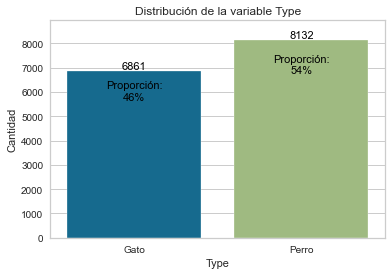

In [16]:
sns.set_style("whitegrid")

a = sns.countplot(data=data_EDA, x = "Type")
a.set(ylabel = "Cantidad", title = "Distribución de la variable Type", ylim = (0, max(data_EDA.Type.value_counts())*1.1))

for ax in a.patches:
  x, y = ax.get_xy()
  width = ax.get_width()
  height = ax.get_height()
  a.annotate("Proporción:\n" + f'{height/data_EDA.shape[0]*100:.0f}%', (x + width/2, y + 0.85*height),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
  a.annotate(f'{height:.0f}', (x + width/2, y + 1*height),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')


Como se puede ver en la gráfica hay un 8% más de perros que de gatos (aproximadamente 1271 más perros). Hay que tener en cuenta que lo que se está midiendo son observaciones en el dataset y algunas observaciones son grupos de mascotas que se adoptan en conjunto. Se analizará cómo es el tiempo de adopción de cada grupo cruzando esta variable también con el sexo del animal.

### Variable AdoptionSpeed

In [64]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
import math
import seaborn as sns

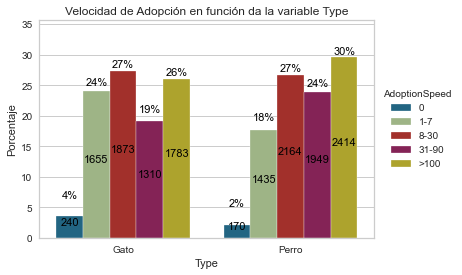

In [247]:
df_plot_1 = data_EDA.groupby(["Type"])["AdoptionSpeed"].value_counts().reset_index(name="count")
df_plot_1 = df_plot_1.merge(data_EDA["Type"].value_counts().reset_index(name  = "count"), how = "left", left_on = "Type", right_on="index")
df_plot_1["Porcentaje"] = df_plot_1.count_x / df_plot_1.count_y * 100

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")

a = sns.barplot(data=df_plot_1, x = "Type", y = "Porcentaje", hue = "AdoptionSpeed", saturation = 0.6)
a.legend(title="AdoptionSpeed",loc="center left",bbox_to_anchor=(1, 0.5))
a.set(ylabel = "Porcentaje", 
ylim = (0, max(df_plot_1.Porcentaje)*1.2),
title = "Velocidad de Adopción en función da la variable Type")


#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

z = 0
for ax in a.patches:
    width = ax.get_width()
    height = ax.get_height()
    x, y = ax.get_xy()
    a.annotate(f'{height*data_EDA.Type.value_counts()[(z%2==0)*1]/100:.0f}', (x + width/2, height/2),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    a.annotate(f'{round(height,2):.0f}%', (x + width/2, y + height + 3 - height/10),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    z = z + 1

Se puede obsevar en la gráfica anterior cómo los perros tienden a tardar más en adoptarse, se puede ver cómo los valores de las categorías de mayor tiempo de adopción la cantidad de observaciones es mayor en los perros que en los gatos.

### Variable Gender

In [67]:
df_plot = data_EDA.copy()
df_plot["Cantidades"] = data_EDA.AdoptionSpeed
df_plot = df_plot.groupby(['Type', 'MaturitySize', 'Gender', 'AdoptionSpeed'])['Cantidades'].aggregate('count').reset_index()
total_plot = data_EDA.copy()
total_plot["Totales"] = data_EDA.AdoptionSpeed
total_plot = total_plot.groupby(['Type', 'MaturitySize', 'Gender'])['Totales'].aggregate('count').reset_index()
df_plot["Totales"] = df_plot.merge(total_plot, how="left", on = ['Type', 'MaturitySize', 'Gender'])["Totales"]
df_plot["Frecuencia"] = round(df_plot.Cantidades / df_plot.Totales * 100)
total_plot_2 = total_plot.groupby(['Type', 'MaturitySize'])['Totales'].aggregate('sum').reset_index()
total_plot_2["Porcentaje"] = round(100 * total_plot_2['Totales'] / total_plot_2.groupby('Type')['Totales'].transform('sum'))
total_plot_3 = df_plot.groupby(['Type', 'Gender','AdoptionSpeed'])['Cantidades'].aggregate('sum').reset_index()
total_plot_3["Porcentaje"] = round(100 * total_plot_3['Cantidades'] / total_plot_3.groupby(['Type', 'Gender'])['Cantidades'].transform('sum'))
total_plot_4 = total_plot_3.groupby(['Type', 'Gender'])['Cantidades'].aggregate('sum').reset_index()
total_plot_4["Porcentaje"] = round(100 * total_plot_4['Cantidades'] / total_plot_4.groupby(['Type'])['Cantidades'].transform('sum'))

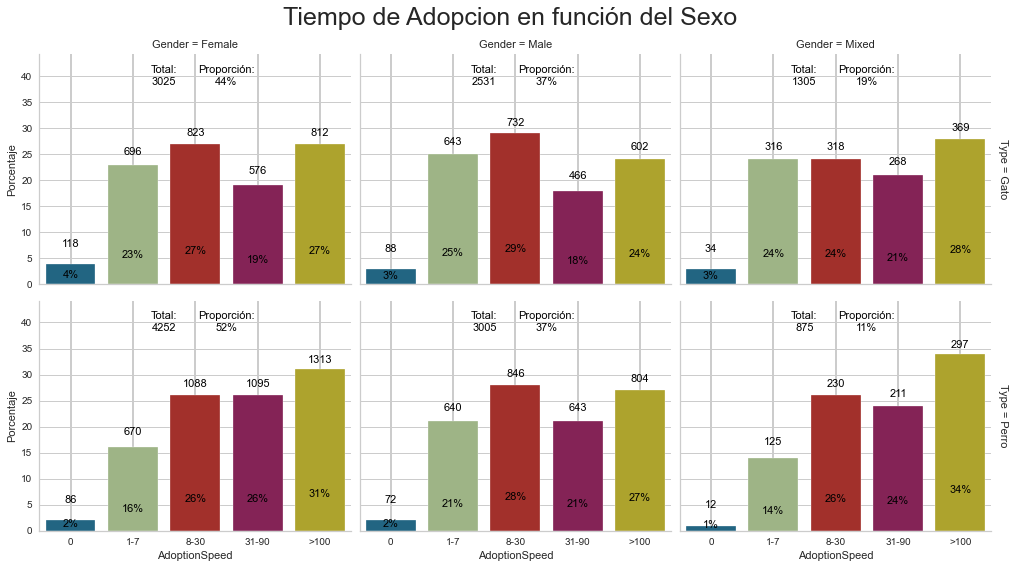

In [68]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = total_plot_3,
                  row = 'Type', col='Gender',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='AdoptionSpeed', y = 'Porcentaje', dodge = True,
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Porcentaje", ylim = (0, max(total_plot_3.Porcentaje)*1.3))
g.fig.suptitle("Tiempo de Adopcion en función del Sexo", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)


for z, ax in enumerate(g.axes.flat):
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{total_plot_4.Cantidades[z]:.0f}', (1.5, max(total_plot_3.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    ax.annotate("Proporción:\n" + f'{total_plot_4.Porcentaje[z]:.0f}%', (2.5, max(total_plot_3.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
   
    for w, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{total_plot_3.Cantidades[w + z * 5]:.0f}', (x + width/2, y + height + 3 - height/15),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        ax.annotate(f'{height:.0f}%', (x + width/2, height/5),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
       

En el gráfico anterior se muestran quéla proporción de observaciones para la variable velocidad de adopción según el sexo del animal y el tipo de animal.
Se apreciar cómo los gatos tienden a adoptarse antes que los perros. Además en los perros hay una preferencia por adoptar perros machos, algo que no se puede asegurar en los gatos.

### Variable MaturitySize

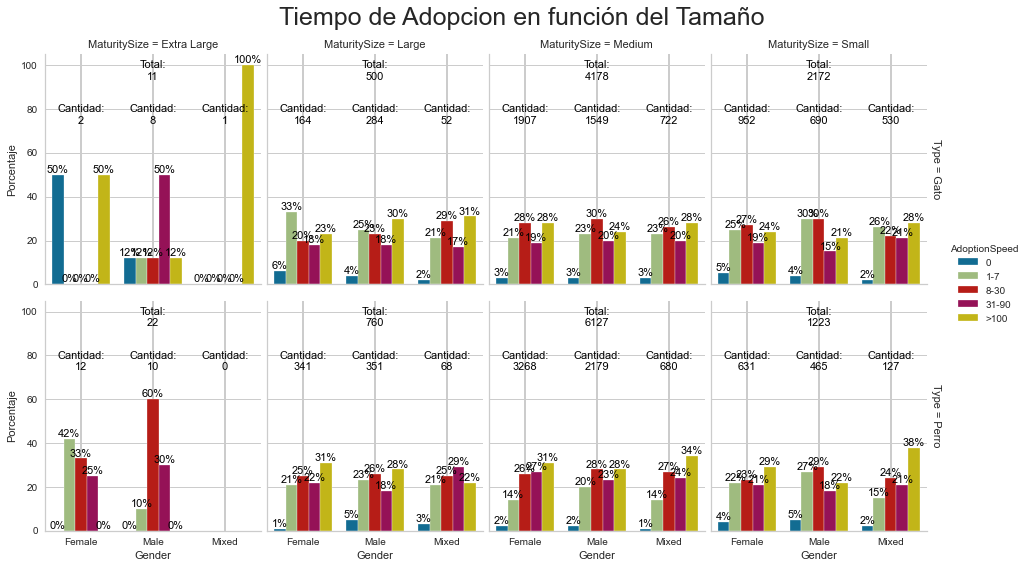

In [71]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot,
                  row = 'Type', col='MaturitySize',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='Gender', y = 'Frecuencia', dodge = True,
                hue = 'AdoptionSpeed', saturation = 0.8, palette = sns.color_palette(), estimator = np.mean)
g.add_legend(title="AdoptionSpeed")
g.set(ylabel = "Porcentaje")
g.fig.suptitle("Tiempo de Adopcion en función del Tamaño", size = 25 )
g.tight_layout()
g.legend.set_visible(True)
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

z = 0
for ax in g.axes.flat:
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.xaxis.set_major_locator(FixedLocator([0.5, 1.5, 2.5]))
    #ax.set_xticks([0, 1, 2])
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{total_plot_2.Totales[z]:.0f}', (1, 95),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    j = 0
    for i in df_plot.Gender.unique():
      ax.annotate("Cantidad:\n" + f'{total_plot.Totales[j + z * 3]:.0f}', (j, 75),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
      j = j + 1
    z = z + 1
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')



El gráfico se vuelve difícil de leer por lo tanto se irá gráfico por gráfico.
Comenzaremos por los **perros**.
- Extra grande: Hay muy pocas observaciones, son todas observaciones de 1 solo perro. Las hembras tienden a adoptarse primero, demoran algo más los machos.
- Grande: Los machos tienden a adoptarse antes que las hembras. En los grupos de perros ("Mixed") se mantiene algo pareja la distribución, se adopta un mayor pocentaje de perros antes de los 90 días que en los otros grupos.
- Mediano: Es el grupo que más obseraviones de perros tiene. Tanto en las hembras como en los machos, se demora algo más en adoptarse respecto a los perros de tamaño grande (más marcado en las hembras). Esto se aprecia también en Mixed.
- Chico: De los perros machos, el tamaño chico es el que más rápido se adopta. Ocurre lo mismo en el hembras, aunque menos marcado. En el grupo Mixed es dónde más tiempo se demoran en adoptarlos. Esto último se podría vincular a que se adoptan perros chicos para estacios reducidos y por lo tanto se quiere adoptar solo 1 y no un grupo de animales.
En resumen, hay una preferencia por los perros chicos cuando se debe adoptar 1 solo perro. Cuando se trata de un grupo de perros se prefieren adoptar perros grandes. En cuanto al sexo de los perros, hay una leve tendencia a adoptar machos.

Ahora se analizarán los **gatos**.
- Exrtra grande: Al igual que en los perros hay muy pocas obseraciones. A los pocos que hay se les hace difícil de adoptar.
- Grande: Hay una preferencia por adoptar hembras.
- Mediano: La preferencia por las hembras parace equipararse con la de los machos. En los grupos de gatos se manteniene relativamente constante entre gatos grandes y medianos
- Chico: Hay una preferencia por los gatos machos, y es en el tamaño en el que más se adoptan los grupos de gatos.
En resumen, cuando los gatos son grandes se prefieren las hembras y cuando los gatos son chicos se prefieren los machos. Los grupos de gatos se mantiene relativamente constante.

En este gráfico se aprecia como en todas las categorias y sexos, los gatos se adoptan más rápidos que los perros, lo que marca una tendencia independientemente del sexo o tamaño.

### Varibale Breed
Se creará una nueva variable en el dataset indicando si el animal es de raza pura o cruza. Se analizará a continuación.

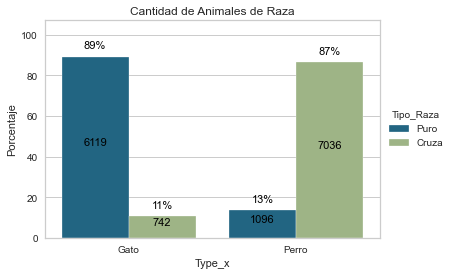

In [249]:
df_plot_5 = data_EDA.groupby(["Type"])["Tipo_Raza"].value_counts().reset_index(name = "count").copy()
df_plot_5 = df_plot_5.merge(data_EDA["Type"].value_counts().reset_index(), how = "left", left_on = "Type", right_on="index")
df_plot_5["Porcentaje"] = df_plot_5["count"] / df_plot_5.Type_y * 100

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")

a = sns.barplot(data=df_plot_5, x = "Type_x", y = "Porcentaje", hue = "Tipo_Raza", saturation = 0.6)
a.legend(title="Tipo_Raza",loc="center left",bbox_to_anchor=(1, 0.5))
a.set(ylabel = "Porcentaje", 
ylim = (0, max(df_plot_5.Porcentaje)*1.2),
title = "Cantidad de Animales de Raza")


#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

z = 0
for ax in a.patches:
    width = ax.get_width()
    height = ax.get_height()
    x, y = ax.get_xy()
    a.annotate(f'{height*data_EDA.Type.value_counts()[(z%2==0)*1]/100:.0f}', (x + width/2, height/2),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    a.annotate(f'{round(height,2):.0f}%', (x + width/2, y + height + 3),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    z = z + 1

Se puede observar que la gran cantidad de perros son cruza y que la gran cantidad de gatos no. Esto se debe a que la mayoría de los gatos son de raza "Domestica".
Qué quiere decir esto? Se los conoce popularmente como, por ejemplo, "gato doméstico europeo". Debido al escazo conocimiento que tiene en el tema es difícil tomar una decisión sobre si considerarlo cruza o no, ya que es un tipo de gato identificable y con razgos característicos. Es por este motivo que se decidió dejarlo como gato de "raza".
Una tabla a continuación para ilustrar lo mencionado en el párrafo anterior.

In [90]:
data_EDA.loc[data_EDA["Type"] == "Gato", "Breed1"].value_counts().reset_index().head(10)

,index,Breed1
0,Domestic,5188
1,Tabby,342
2,Siamese,264
3,Persian,221
4,Calico,105
5,American Shorthair,94
6,Oriental,90
7,Bengal,71
8,Tuxedo,56
9,Tortoiseshell,42


Ahora se analizará el tiempo de adopción en función de si se es de raza o no.

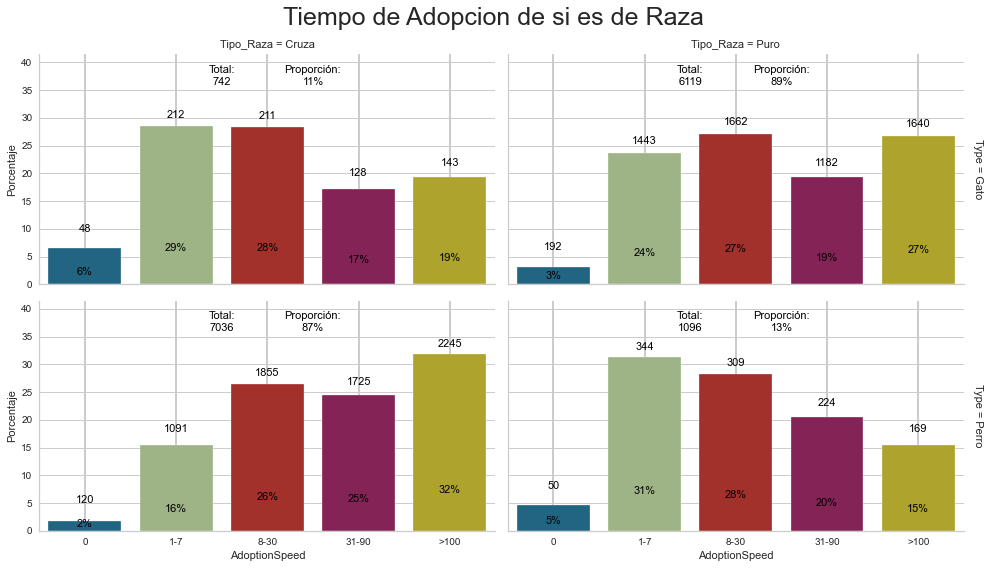

In [96]:
df_plot_6 = data_EDA.groupby(["Type","Tipo_Raza"])["AdoptionSpeed"].value_counts().reset_index(name = "count")
df_plot_6["Porcentaje"] = df_plot_6["count"] / df_plot_6.groupby(["Type","Tipo_Raza"])["count"].transform("sum") * 100
df_plot_6 = df_plot_6.sort_values(["Type","Tipo_Raza", "AdoptionSpeed"]).reset_index()
df_plot_7 = data_EDA.groupby(["Type"])["Tipo_Raza"].value_counts().reset_index(name = "count")
df_plot_7["Porcentaje"] = df_plot_7["count"] / df_plot_7.groupby(["Type"])["count"].transform("sum") * 100
df_plot_7 = df_plot_7.sort_values(["Type","Tipo_Raza"]).reset_index()


sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_6,
                  row = 'Type', col='Tipo_Raza',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='AdoptionSpeed', y = 'Porcentaje', dodge = True,
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Porcentaje", ylim = (0, max(df_plot_6.Porcentaje)*1.3))
g.fig.suptitle("Tiempo de Adopcion de si es de Raza", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)


for z, ax in enumerate(g.axes.flat):
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{df_plot_7["count"][z]:.0f}', (1.5, max(df_plot_6.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    ax.annotate("Proporción:\n" + f'{df_plot_7.Porcentaje[z]:.0f}%', (2.5, max(df_plot_6.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
   
    for w, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{round(height * df_plot_7["count"][z] / 100):.0f}', (x + width/2, y + height + 3 - height/15),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        ax.annotate(f'{height:.0f}%', (x + width/2, height/5),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
       

Es marcada la diferencia entre perros y gatos la velocidad de adopción en función de si el animal es de raza o no. Mientras que varía muy poco en los gatos, con una tendencia a adoptar más rápido a gatos que no son de raza; en los perros influye mucho, ya que los perros de raza tienen a adoptarse antes.
Sería muy útil para este análizar poder categorizar las razas según cualidades características, pero esto no se hará debido a que se necesitan mayores conocimiento sobre el comportamiento y las características físicas de cada raza.

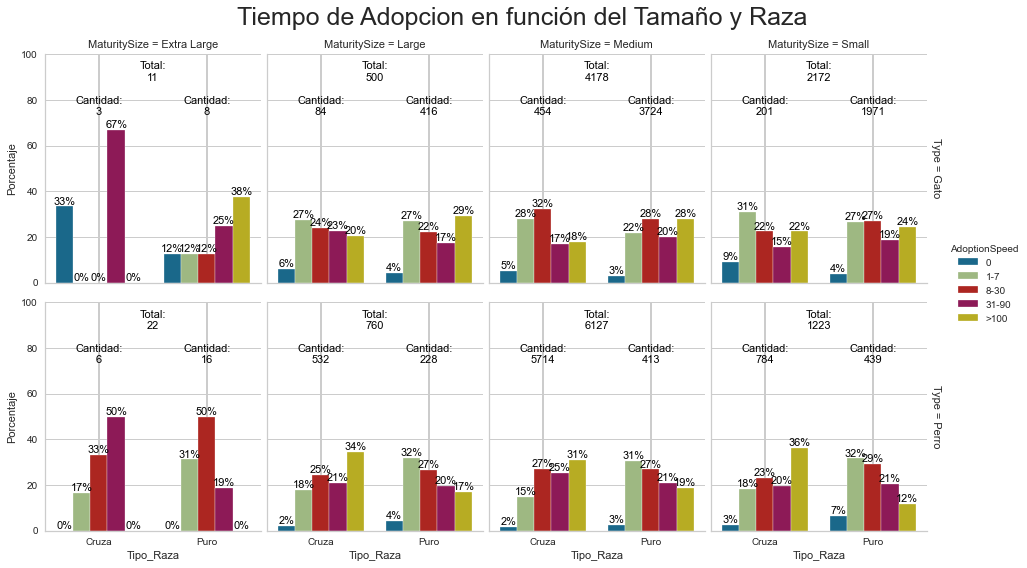

In [97]:
df_plot_8 = data_EDA.groupby(['Type', 'MaturitySize', 'Tipo_Raza'])["AdoptionSpeed"].value_counts().reset_index(name = "count")
df_plot_8["Porcentaje"] = df_plot_8["count"] / df_plot_8.groupby(["Type","MaturitySize", "Tipo_Raza"])["count"].transform("sum") * 100
df_plot_8 = df_plot_8.sort_values(["Type","MaturitySize","Tipo_Raza", "AdoptionSpeed"]).reset_index()
df_plot_9 = data_EDA.groupby(["Type","MaturitySize"])["Tipo_Raza"].value_counts().reset_index(name = "count")
df_plot_9["Porcentaje"] = df_plot_8["count"] / df_plot_8.groupby(["Type"])["count"].transform("sum") * 100
df_plot_9 = df_plot_9.sort_values(["Type", "MaturitySize", "Tipo_Raza"]).reset_index()
df_plot_10 = df_plot_9.groupby(['Type', 'MaturitySize'])["count"].aggregate("sum").reset_index()

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_8,
                  row = 'Type', col='MaturitySize',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='Tipo_Raza', y = 'Porcentaje', dodge = True,
                hue = 'AdoptionSpeed', saturation = 0.7, palette = sns.color_palette(), estimator = np.mean)
g.add_legend(title="AdoptionSpeed")
g.set(ylabel = "Porcentaje",  ylim = (0, 100))
g.fig.suptitle("Tiempo de Adopcion en función del Tamaño y Raza", size = 25 )
g.tight_layout()
g.legend.set_visible(True)
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

z = 0
for ax in g.axes.flat:
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.xaxis.set_major_locator(FixedLocator([0.5, 1.5, 2.5]))
    #ax.set_xticks([0, 1, 2])
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{df_plot_10["count"][z]:.0f}', (0.5, 90),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    j = 0
    for i in df_plot_8.Tipo_Raza.unique():
      ax.annotate("Cantidad:\n" + f'{df_plot_9["count"][j + z * 2]:.0f}', (j, 75),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
      j = j + 1
    z = z + 1
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')


Nuevamente se comenzará por los **perros**.
- Extra grande: Son en su mayoría perros de raza, que se adoptan relativamente rápido. Igualmente la muestra es muy pequeña para sacar conclusiones.
- Grande: Mayor cantidad de perros que no son de raza, aunque este grupo tiene mayor tiempo hasta que sean adoptados. Nuevamente se comprueba la influencia de la raza en los perros.
- Mediano: Gran cantidad de perros cruza, nuevamente con un mayor tiempo de adopción.
- Pequeños: En los perros pequeños se equipara un poco la cantidad de perros de raza con los que no son de raza en este grupo Sigue habiendo una diferencia en los tiempos de adopción de si son de raza o no. En los perros pequeños parece influir mpas esto que en los otros grupos.
Ahora es el turno de los **gatos**. 
- Extra grande: La mayoría de los gatos muy grandes son de raza. En general no son gatos que se adopten rápidamente, pero al tener una muestra muy pequeña es difícil sacar conclusiones
- Grande: Nuevamente son en su mayoría perros de raza (de esperarse dado lo desbalanceada que está el dataset en la variable Tipo_Raza), los gatos que no son de raza se adoptan antes, aunque con una muy leve diferencia.
- Mediano: En los gatos medianos se adoptan más rápido los gatos que son de raza.
- Pequeño: Continúa habiendo una inclinación a adoptar gatos de raza por sobre los gatos que no son de raza.

En conclusión hay una marcada tendencia a adoptar perros de raza, sin importar el tamaño del mismo (en todos los tamaños las 2 categorías de adopción más rápida superan el 30% del total de perros). En los gatos esto no es tan marcado, aunque hay una leve inclinación a adoptar gatos de raza en los tamaños mediano y pequeño. Comparando entre los perros y los gatos se podría decir que los perros de raza se adoptan prácticamente tan rápido como los gatos; los perros que no son de raza son los que bajan en promedio la velocidad de adopción de los perros haciendo que esta sea en promedio mayor respecto a los gatos.

Cuando se analice el estado de salud de los animales se tendrá mayor certeza sobre porqué puede estar sucediendo esto.

### Variable Furlength

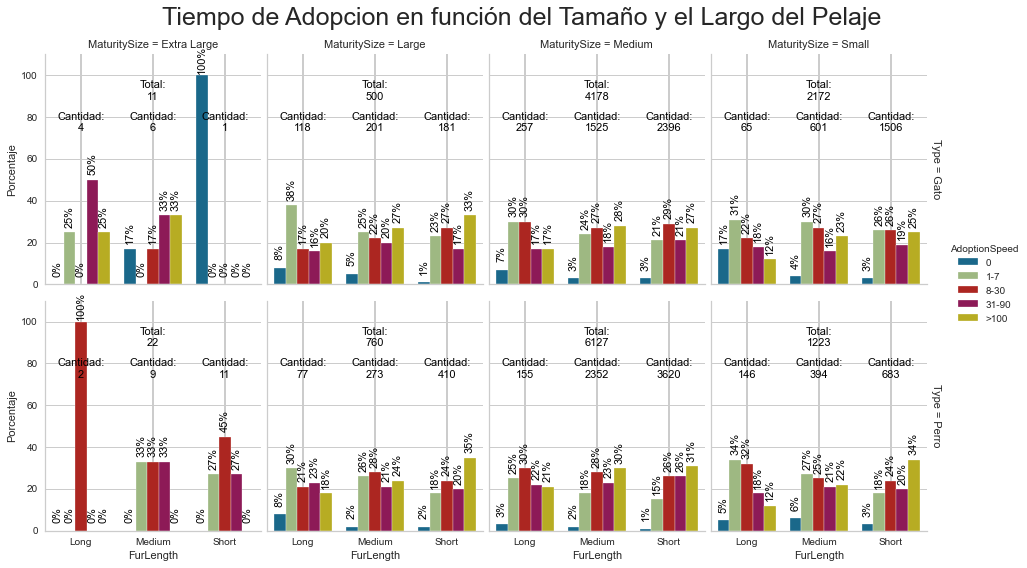

In [99]:
df_plot_14 = data_EDA.groupby(['Type', 'MaturitySize', 'FurLength', 'AdoptionSpeed'])['Quantity'].aggregate('count').reset_index()
total_plot_5 = data_EDA.groupby(['Type', 'MaturitySize', 'FurLength'])['Quantity'].aggregate('count').reset_index()
df_plot_14["Totales"] = df_plot_14.merge(total_plot_5, how="left", on = ['Type', 'MaturitySize', 'FurLength'])['Quantity_y']
df_plot_14["Porcentaje"] = round(df_plot_14.Quantity / df_plot_14.Totales * 100)
total_plot_6 = total_plot_5.groupby(['Type', 'MaturitySize'])['Quantity'].aggregate('sum').reset_index()
total_plot_5["Totales"] = total_plot_5.merge(total_plot_6, how="left", on = ['Type', 'MaturitySize'])['Quantity_y']
total_plot_5["Porcentaje"] = round(100 * total_plot_5['Quantity'] / total_plot_5['Totales'])
total_plot_7 = total_plot_6.groupby(['Type'])['Quantity'].aggregate('sum').reset_index()
total_plot_6["Totales"] = total_plot_6.merge(total_plot_7, how="left", on = ['Type'])['Quantity_y']
total_plot_6["Porcentaje"] = round(100 * total_plot_6['Quantity'] / total_plot_6['Totales'])

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_14,
                  row = 'Type', col='MaturitySize',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='FurLength', y = 'Porcentaje', dodge = True,
                hue = 'AdoptionSpeed', saturation = 0.7, palette = sns.color_palette(), estimator = np.mean)
g.add_legend(title="AdoptionSpeed")
g.set(ylabel = "Porcentaje",  ylim = (0, 110))
g.fig.suptitle("Tiempo de Adopcion en función del Tamaño y el Largo del Pelaje", size = 25 )
g.tight_layout()
g.legend.set_visible(True)
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

z = 0
for ax in g.axes.flat:
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.xaxis.set_major_locator(FixedLocator([0.5, 1.5, 2.5]))
    #ax.set_xticks([0, 1, 2])
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{total_plot_6["Quantity"][z]:.0f}', (1, 90),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    j = 0
    for i in total_plot_5.FurLength.unique():
      ax.annotate("Cantidad:\n" + f'{total_plot_5["Quantity"][j + z * 3]:.0f}', (j, 75),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
      j = j + 1
    z = z + 1
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height + 5),
                    ha='center', va='center', fontsize=11, rotation=90, color='black', xytext=(0, 5),
                    textcoords='offset points')


Se analizan primeros los **perros**.
- Extra Grande: Se adoptan a una "velocidad media", no se aprecia una gran diferencia en función del largo del pelaje en este grupo.
- Grande, Mediano y Chico: Se aprecia una preferencia por los perros de pelaje largo en todos lo tamaños. El comportamiento de la variable tiempo de adopción sigue el mismo patrón independientemente del tamaño del animal.

Se continúa con los **gatos**.
- Extra Grande: Muy poca cantidad de variables, no se pueden sacar muchas conclusiones. El único gato de pelaje corto se adoptó rápidamente, es sospechoso que solo haya 1 observación con estas características entre los más de 7000 gatos, ¿será una observación mal cargada?.
- Grande, Mediano y Chico: Se puede observar el mismo patrón que en los perros.

### Variable Color

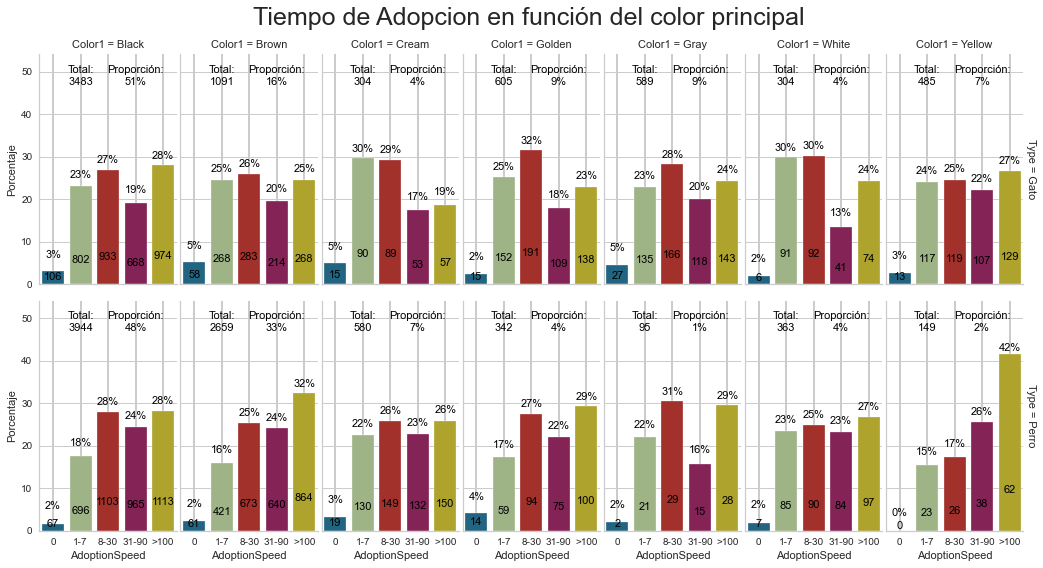

In [101]:
df_plot_18 = data_EDA.groupby(["Type","Color1"])["AdoptionSpeed"].value_counts().reset_index(name = "count")
df_plot_18["Porcentaje"] = df_plot_18["count"] / df_plot_18.groupby(["Type","Color1"])["count"].transform("sum") * 100
df_plot_18 = df_plot_18.sort_values(["Type","Color1", "AdoptionSpeed"]).reset_index()
df_plot_19 = data_EDA.groupby(["Type"])["Color1"].value_counts().reset_index(name = "count")
df_plot_19["Porcentaje"] = df_plot_19["count"] / df_plot_19.groupby(["Type"])["count"].transform("sum") * 100
df_plot_19 = df_plot_19.sort_values(["Type","Color1"]).reset_index()


sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_18,
                  row = 'Type', col='Color1',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='AdoptionSpeed', y = 'Porcentaje', dodge = True,
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Porcentaje", ylim = (0, max(df_plot_18.Porcentaje)*1.3))
g.fig.suptitle("Tiempo de Adopcion en función del color principal", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)


for z, ax in enumerate(g.axes.flat):
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{df_plot_19["count"][z]:.0f}', (1, max(df_plot_18.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    ax.annotate("Proporción:\n" + f'{df_plot_19.Porcentaje[z]:.0f}%', (3, max(df_plot_18.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
   
    for w, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{round(height * df_plot_19["count"][z] / 100):.0f}', (x + width/2, height/5),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height + 3 - height/15),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

**Gatos**
- Más de la mitad de los gatos tienen color principal el negro (51%), seguido por el marrón (16%).
- Los gatos color crema son los que más rápido se adoptan, aunque esta diferencia de velocidad de adopción no es tan marcada.
- El resto de los colores se comportan bastante parecido, el color de gatos que más demora en adoptarse son los gatos negros, probablemente por la gran abundancia de los mismos.

**Perros**
- Casi la mitad de los perros tienen como color principal el negro (48%), seguido por el color marrón (33%). Entre ambos suman el 80% de todos los perros.
- Los perros que más demoran en adoptarse son los perros de color amarillo, esta tendencia es marcada por sobre los otros colores.
- El resto de los colores se comportan muy similar.

### Variable Health

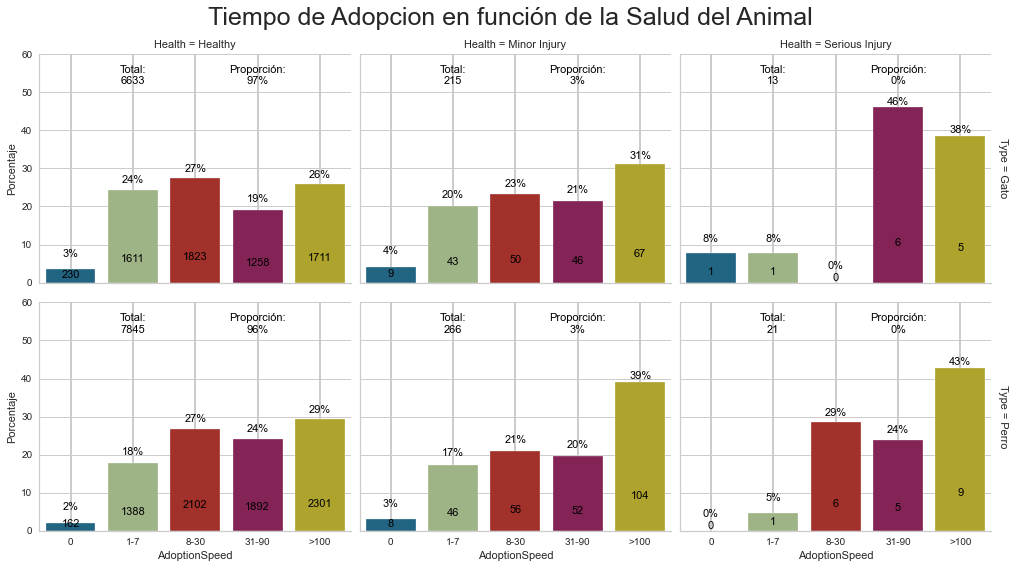

In [102]:
df_plot_20 = data_EDA.groupby(["Type","Health"])["AdoptionSpeed"].value_counts().reset_index(name = "count")
df_plot_20["Porcentaje"] = df_plot_20["count"] / df_plot_20.groupby(["Type","Health"])["count"].transform("sum") * 100
df_plot_20 = df_plot_20.sort_values(["Type","Health", "AdoptionSpeed"]).reset_index()
df_plot_21 = data_EDA.groupby(["Type"])["Health"].value_counts().reset_index(name = "count")
df_plot_21["Porcentaje"] = df_plot_21["count"] / df_plot_21.groupby(["Type"])["count"].transform("sum") * 100
df_plot_21 = df_plot_21.sort_values(["Type","Health"]).reset_index()

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_20,
                  row = 'Type', col='Health',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='AdoptionSpeed', y = 'Porcentaje', dodge = True,
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Porcentaje", ylim = (0, max(df_plot_20.Porcentaje)*1.3))
g.fig.suptitle("Tiempo de Adopcion en función de la Salud del Animal", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)


for z, ax in enumerate(g.axes.flat):
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{df_plot_21["count"][z]:.0f}', (1, max(df_plot_20.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    ax.annotate("Proporción:\n" + f'{df_plot_21.Porcentaje[z]:.0f}%', (3, max(df_plot_20.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
   
    for w, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{round(height * df_plot_21["count"][z] / 100):.0f}', (x + width/2, height/5),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height + 3 - height/15),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

Es muy marcada la diferencia en la cantidad de animales sanos contra los animales enfermos, el 96% de los perros y gatos se encuentran sanos. El grupo de muy lastimados resulta difícil sacar conclusiones debido a la pequeña cantidad de observaciones.
Los animales con lastimaduras, aunque sean leves, tienen menor velocidad de adopción que los animales sanos; este comportamiento se aprecia en perros y gatos.

### Variable Age

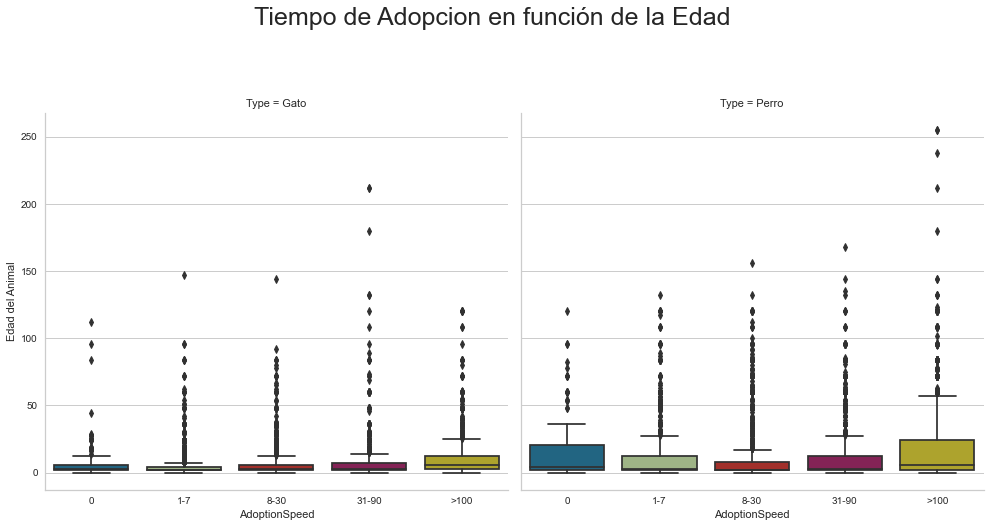

In [103]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = data_EDA,
                  col='Type', 
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.boxplot, x='AdoptionSpeed', y = 'Age',
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Edad del Animal")
g.fig.suptitle("Tiempo de Adopcion en función de la Edad", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

Se puede observar que en los gatos, los que más tiempo demoran en adoptarse son los gatos en promedio más adultos. En los perros no es tán así, sorprende la gran dispersión en las edades entre los que más rápido y más lento se adoptan en los perros.
Todas las categorías tienen una fuerte asimetría hacia la derrecha.

In [ ]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = data_EDA,
                  col='AdoptionSpeed', 
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.boxplot, x='Type', y = 'Age',
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Edad del Animal")
g.fig.suptitle("Tiempo de Adopcion en función de la Edad", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

Al igual que en el gráfico anterior se observa un mayor dispersión en la eda entre los perros que entre los gatos.
Entre los animales que más rápido se adoptan los gatos tienen promedio menor edad, mientras que entre los que más demoran en adoptarse, tienen un promedio más similar, aunque esto no se pueda definir por la gran escala del gráfico. Se estudiará directamente el promedio de la edad a continuación. 
En general la edad de los gatos parece en promedio ser menor que la de los perros, pero este se comprobará a continuación.

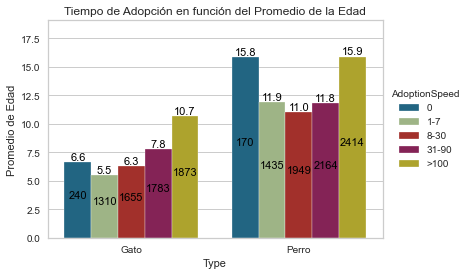

In [257]:
df_plot_24 = data_EDA.groupby(["Type", "AdoptionSpeed"])["Age"].mean().reset_index(name = "count")
df_plot_24 = df_plot_24.sort_values(["Type", "AdoptionSpeed"],ascending=[False, True])

df_plot_24["Total"] = data_EDA.groupby("Type")["AdoptionSpeed"].value_counts().reset_index(name = "Total")["Total"]
#df_plot_24 = df_plot_15.merge(data_EDA["Type"].value_counts(), how = "left", on = "Type")
#df_plot_24["Porcentaje"] = df_plot_15.count_x / df_plot_15.count_y * 100

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")

a = sns.barplot(data=df_plot_24, x = "Type", y = "count", hue = "AdoptionSpeed", saturation = 0.6)
a.legend(title="AdoptionSpeed",loc="center left",bbox_to_anchor=(1, 0.5))
a.set(ylabel = "Promedio de Edad", 
ylim = (0, max(df_plot_24["count"])*1.2),
title = "Tiempo de Adopción en función del Promedio de la Edad")


#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

filas = df_plot_24.shape[0] - 1
z = 0
for ax in a.patches:
    width = ax.get_width()
    height = ax.get_height()
    x, y = ax.get_xy()
    indice = filas - np.where(df_plot_24["count"] == height)[0][0]
    a.annotate(f'{df_plot_24.loc[indice, "Total"]:.0f}', (x + width/2, height/2),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    a.annotate(f'{height:.1f}', (x + width/2, y + height),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    z = z + 1

En el gráfico anterior se muestran los promedios de edad de los animales y su velocidad de adopción. Sorprende la diferencia en el promedio de edad entre los perros y los gatos, teniendo también en cuenta que los gatos generalmente viven más. Además en los gatos hay una correlación entre la edad y la velocidad de adopción que en los perros no es tan clara.
Posiblemente, debido a que los perros tienen a ser mas dañinos en el hogar, se prefieren perros adultos que ya son animales más tranquilos. Sorprende tambien que para los gatos que se adoptaron en 8-30 días solo se adoptaron 240 gatos.

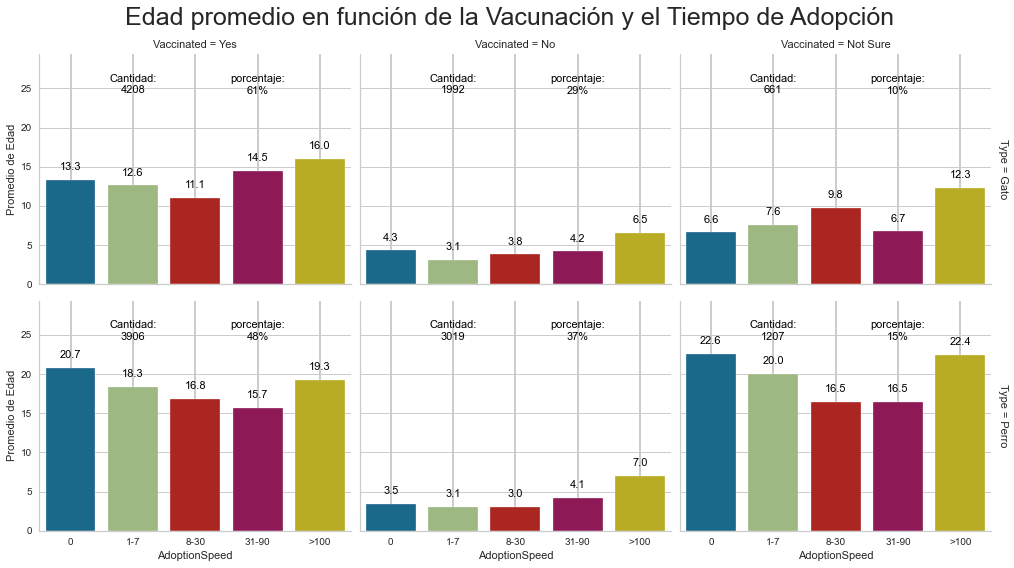

In [256]:
df_plot_25 = data_EDA.groupby(["Type", "Vaccinated", "AdoptionSpeed"])["Age"].mean().reset_index(name = "count")
df_plot_26 = data_EDA.groupby(["Type"])["Vaccinated"].value_counts().reset_index(name = "count")
df_plot_26["Porcentaje"] = df_plot_26["count"]/df_plot_26.groupby(["Type"])["count"].transform("sum")*100
df_plot_27 = data_EDA.groupby(["Type"])["Vaccinated"].value_counts().reset_index(name = "count")
df_plot_27["Porcentaje"] = df_plot_27["count"]/df_plot_27.merge(df_plot_27.groupby(["Type"])["count"].sum(), on = "Type", how = "left")["count_y"]*100

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_25,
                  row = 'Type', col='Vaccinated',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='AdoptionSpeed', y = 'count', dodge = True,
                saturation = 0.7, palette = sns.color_palette(), estimator = np.mean)
g.set(ylabel = "Promedio de Edad",  ylim = (0, max(df_plot_25["count"])*1.3))
g.fig.suptitle("Edad promedio en función de la Vacunación y el Tiempo de Adopción", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

z = 0
for ax in g.axes.flat:
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.xaxis.set_major_locator(FixedLocator([0.5, 1.5, 2.5]))
    #ax.set_xticks([0, 1, 2])
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Cantidad:\n" + f'{df_plot_26["count"][z]:.0f}', (1, max(df_plot_25["count"])*1.1),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    ax.annotate("porcentaje:\n" + f'{df_plot_26["Porcentaje"][z]:.0f}%', (3, max(df_plot_25["count"])*1.1),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    j = 0
    #for i in total_plot_5.FurLength.unique():
    #  ax.annotate("Cantidad:\n" + f'{total_plot_5["Quantity"][j + z * 3]:.0f}', (j, 75),
    #  ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
    #  textcoords='offset points')
    #  j = j + 1
    z = z + 1
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.1f}', (x + width/2, y + height + 1),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')


Este es un gráfico interesante. Primero, destacar la diferencia de edad que hay entre perros y gatos. Segundo, tanto para perros como para gatos, existe una relación entre la edad y el tiempo de adopción para los que se encuentran no vacudados. Para los vacunados esto es muy diferente, ya que su promedio de edad es mucho mayor y no existe esta relación de forma marcada. Llama la atención que los perros de los que no se está seguro que hayan sido vacunados, tengan la mayor edad promedio.

### Variable Fee

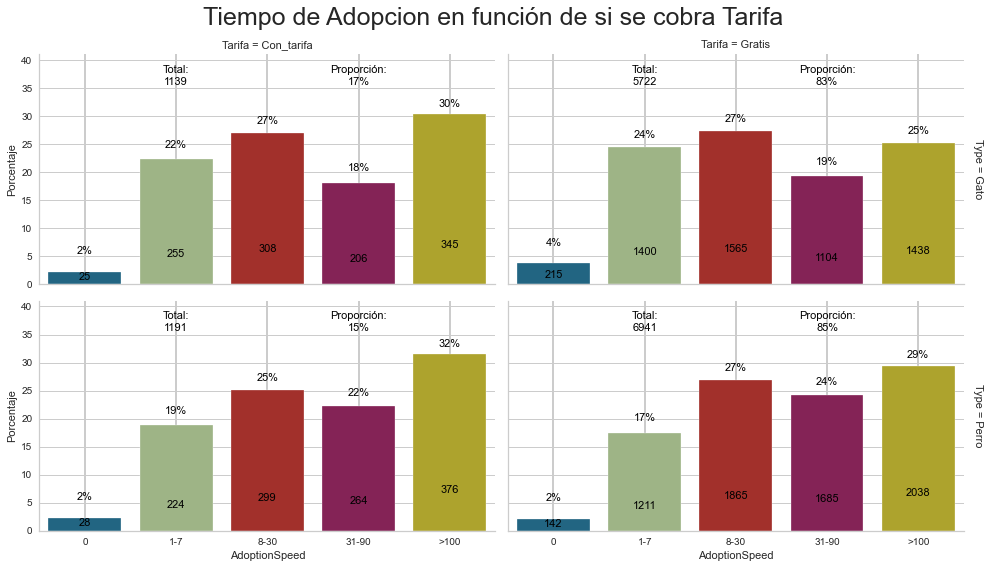

In [115]:
df_plot_32 = data_EDA.groupby(["Type","Tarifa"])["AdoptionSpeed"].value_counts().reset_index(name = "count")
df_plot_32["Porcentaje"] = df_plot_32["count"] / df_plot_32.groupby(["Type","Tarifa"])["count"].transform("sum") * 100
df_plot_32 = df_plot_32.sort_values(["Type","Tarifa", "AdoptionSpeed"]).reset_index()
df_plot_33 = data_EDA.groupby(["Type"])["Tarifa"].value_counts().reset_index(name = "count")
df_plot_33["Porcentaje"] = df_plot_33["count"] / df_plot_33.groupby(["Type"])["count"].transform("sum") * 100
df_plot_33 = df_plot_33.sort_values(["Type","Tarifa"]).reset_index()

sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = df_plot_32,
                  row = 'Type', col='Tarifa',
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='AdoptionSpeed', y = 'Porcentaje', dodge = True,
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Porcentaje", ylim = (0, max(df_plot_32.Porcentaje)*1.3))
g.fig.suptitle("Tiempo de Adopcion en función de si se cobra Tarifa", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)


for z, ax in enumerate(g.axes.flat):
    ax.grid(which = "major", linewidth = 2, axis = "x")
    #ax.set_xticklabels(data_EDA.AdoptionSpeed.unique())
    ax.annotate("Total:\n" + f'{df_plot_33["count"][z]:.0f}', (1, max(df_plot_32.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
    ax.annotate("Proporción:\n" + f'{df_plot_33.Porcentaje[z]:.0f}%', (3, max(df_plot_32.Porcentaje)*1.15),
      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
      textcoords='offset points')
   
    for w, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{round(height * df_plot_33["count"][z] / 100):.0f}', (x + width/2, height/5),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height + 3 - height/15),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

Tanto para perros como para gatos, el 85% de las adopciones fueron de forma gratuita. Las adopciones gratuitas tienen una mayor velocidad de adopción, aunque esto no es tan marcado como se esperaba.

### Varible Quantity

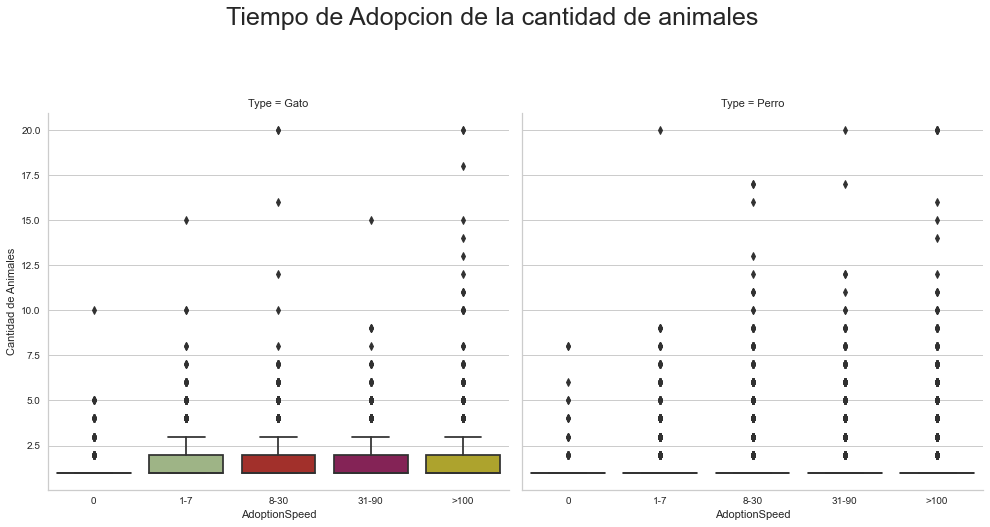

In [117]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = data_EDA,
                  col='Type', 
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.boxplot, x='AdoptionSpeed', y = 'Quantity',
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Cantidad de Animales")
g.fig.suptitle("Tiempo de Adopcion de la cantidad de animales", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

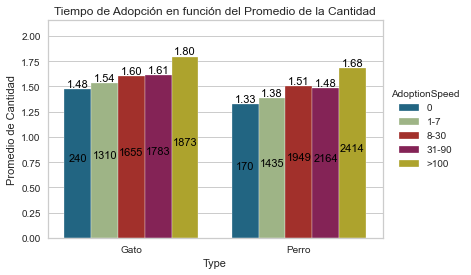

In [259]:
df_plot_34 = data_EDA.groupby(["Type", "AdoptionSpeed"])["Quantity"].mean().reset_index(name = "count")
df_plot_34 = df_plot_34.sort_values(["Type", "AdoptionSpeed"],ascending=[False, True])

df_plot_34["Total"] = data_EDA.groupby("Type")["AdoptionSpeed"].value_counts().reset_index(name = "Total")["Total"]

#df_plot_24 = df_plot_15.merge(data_EDA["Type"].value_counts(), how = "left", on = "Type")
#df_plot_24["Porcentaje"] = df_plot_15.count_x / df_plot_15.count_y * 100




sns.set_style("whitegrid")

#sns.set_style(style = "ticks")

a = sns.barplot(data=df_plot_34, x = "Type", y = "count", hue = "AdoptionSpeed", saturation = 0.6)
a.legend(title="AdoptionSpeed",loc="center left",bbox_to_anchor=(1, 0.5))
a.set(ylabel = "Promedio de Cantidad", 
ylim = (0, max(df_plot_34["count"])*1.2),
title = "Tiempo de Adopción en función del Promedio de la Cantidad")


#x_labels = data_EDA.AdoptionSpeed.unique()
#g.set(xticks=[0, 1, 2, 3, 4], xticklabels=x_labels)

filas = df_plot_24.shape[0] - 1
z = 0
for ax in a.patches:
    width = ax.get_width()
    height = ax.get_height()
    x, y = ax.get_xy()
    indice = filas - np.where(df_plot_34["count"] == height)[0][0]
    a.annotate(f'{df_plot_34.loc[indice, "Total"]:.0f}', (x + width/2, height/2),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    a.annotate(f'{height:.2f}', (x + width/2, y + height),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    z = z + 1

Como se había visto en la variable **Gender**, hay más grupos de animales entre los gatos que entre los perros. Es por esto los promedios de la variable cantidad son mayores en los gatos que en los perros. Además, se aprecia una correlación positiva entre el promedio de **Quantity** y los tiempos de adopción de los animales.

### Variable VideoAmt

Esta variable indica la cantidad de videos que hay para cada observación.

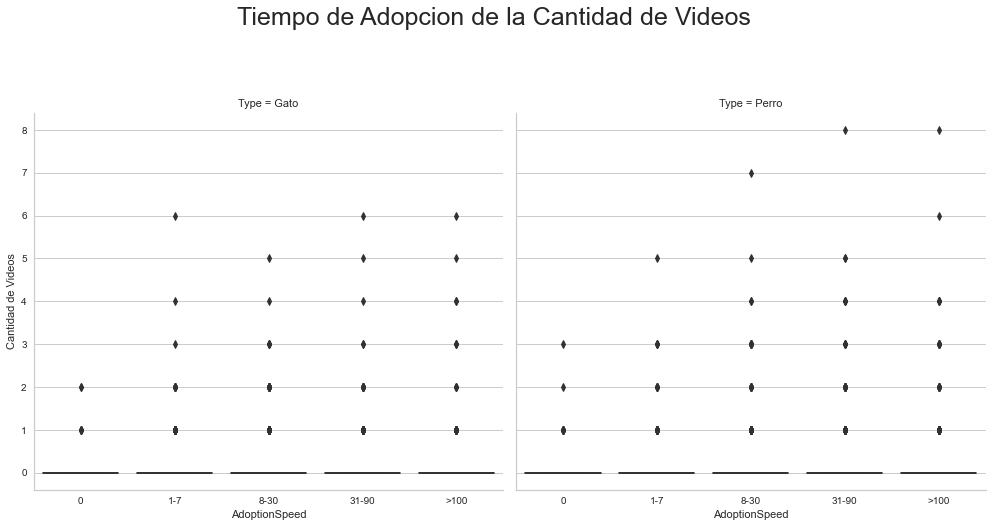

In [288]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = data_EDA,
                  col='Type', 
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.boxplot, x='AdoptionSpeed', y = 'VideoAmt',
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Cantidad de Videos")
g.fig.suptitle("Tiempo de Adopcion de la Cantidad de Videos", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

La gran mayoría de los valores son 0, la variable presenta una gran asimetría hacia la derecha. Es por esto que se analizarán los datos por medio de una tabla para que sean más fáciles de ver.

In [335]:
df_VideoAmt = data_EDA.groupby(["Type"])["VideoAmt"].value_counts().reset_index(name = "Cantidad")
df_VideoAmt["Porcentaje"] = df_VideoAmt.merge(data_EDA.Type.value_counts().reset_index(),
how = "left", left_on = "Type", right_on="index")["Type_y"]
df_VideoAmt["Porcentaje"] = round(df_VideoAmt["Cantidad"] / df_VideoAmt["Porcentaje"] * 100,2)
df_VideoAmt

,Type,VideoAmt,Cantidad,Porcentaje
0,Gato,0,6596,96.14
1,Gato,1,197,2.87
2,Gato,2,47,0.69
3,Gato,3,10,0.15
4,Gato,4,5,0.07
5,Gato,5,3,0.04
6,Gato,6,3,0.04
7,Perro,0,7823,96.20
8,Perro,1,220,2.71
9,Perro,2,45,0.55


Como se puede ver en la tabla, la gran mayoría de los perros y gatos no tienen videos, solo menos del 4% tienen al menos 1.

### Variable PhotoAmt

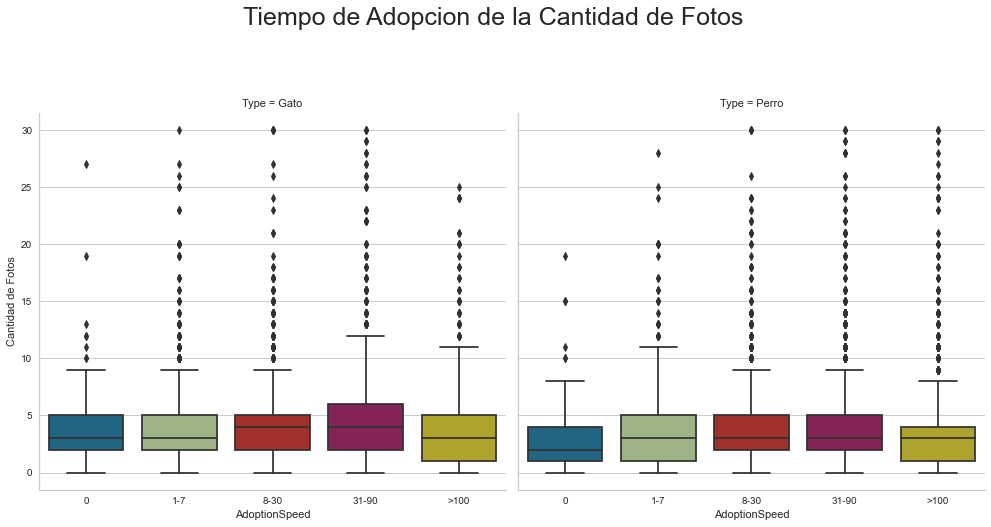

In [338]:
sns.set_style("whitegrid")

#sns.set_style(style = "ticks")
g = sns.FacetGrid(data = data_EDA,
                  col='Type', 
                  margin_titles=True, legend_out = True, height=4, aspect=1.5)
g.map_dataframe(sns.boxplot, x='AdoptionSpeed', y = 'PhotoAmt',
               saturation = 0.6, palette = sns.color_palette())

g.set(ylabel = "Cantidad de Fotos")
g.fig.suptitle("Tiempo de Adopcion de la Cantidad de Fotos", size = 25 )
g.tight_layout()
g.fig.set_size_inches(14, 8) 

Tanto en los perros, como en los gatos, los animales que más rápido se adoptan tienen menor cantidad de fotos que los que se adoptan en 8-30 días o 31-90 días. Esto no es del todo válido para los que se adoptan en más de 100 días. Nuevamente, gran asimetría hacia la derecha.

## 2.2. Lectura de Archivos Json

### Análisis de sentimiento

<p style="text-align:justify;"> Existe una carpeta que contiene información de los resultados del análisis de sentimiento ya procesado por una API de Google. Se recorre cada archivo del tipo json, se extrae la información del score y magnitude y se incorpora al dataset tabular. </p>

In [5]:
# Función para procesar archivos JSON en un directorio y guardarlos en un CSV
def procesar_json(directorio, nom_csv):
    
    # Inicializar el DataFrame
    dataset = pd.DataFrame(columns=["PetID", "doc_magnitude", "doc_score"])

    # Recorrer el directorio y buscar archivos JSON
    for ruta, directorios, archivos in os.walk(directorio):
        for archivo in archivos:
            if archivo.endswith(".json"):
                ruta_completa = os.path.join(ruta, archivo)
                with open(ruta_completa, "r", encoding="utf-8") as file:
                    try:
                        json_data = json.load(file)
    
                        # Buscar las etiquetas en el archivo JSON
                        documentSentiment = json_data.get("documentSentiment", {})
                        magnitude = documentSentiment.get("magnitude", None)
                        score = documentSentiment.get("score", None)

                        if magnitude is not None and score is not None:
                                
                            # Obtener el nombre de archivo sin extensión
                            nombre_archivo = os.path.splitext(archivo)[0]
                            
                            # actualizar el dataset
                            dataset.loc[len(dataset)] = [nombre_archivo, magnitude, score]
                                            
                            
                    except json.JSONDecodeError:
                        print(f"Error al decodificar JSON en {ruta_completa}")

    dataset.to_csv(os.path.join("data_txt", nom_csv), index=False)
    print(f"Se genero correctamente el archivo {nom_csv}.")

In [ ]:
# Directorio en donde se encuentran los archivos JSON de analisis de sentimiento del train
dir_train = "./dataset/train_sentiment"
procesar_json(dir_train, nom_csv="sentiment_train.csv")

# Directorio en donde se encuentran los archivos JSON de analisis de sentimiento de test
dir_test = "./dataset/test_sentiment"
procesar_json(dir_test, nom_csv="sentiment_test.csv")

In [6]:
# Incoporar los datos extraidos de los archivos csv generados en el chunk anterior al dataset llamado data y data_test
train_sentiment = pd.read_csv("./dataset/sentiment_train.csv")
test_sentiment = pd.read_csv("./dataset/sentiment_test.csv")

# Realizar la unión entre data y "sentiment_train" en función de la clave común "petId"
data = data.merge(train_sentiment, on="PetID", how="left")

# Realizar la unión entre data_test y "sentiment_test" en función de la clave común "petId"
test_con_sentiment = data_test.merge(test_sentiment, on="PetID", how="left")

### Procesamiento de imágenes

<p style="text-align:justify;"> Existe una carpeta que contiene información de los resultados del procesamiento de imágenes que ya fueron procesados por Google's Vision API. Se recorre cada archivo del tipo json, se extrae la información del score y calcula un promedio según description que pertenece a Label Annotation y se genera un nuevo archivo del tipo csv y finalmente se hace el merge al dataset tabular. Esto generó una variable por cada description única promediándose su score para cada una de ellas quedando un total 1290 variables. Luego al aplicar el mismo proceso al dataset de test, nos encontramos con distintos valores de description (944 variables), lo que nos obligó a homogenizar la dimensión de ambos dataset (tomando como base las variables del dataset train) a través de una intersección entre sus columnas. </p>

In [8]:
# Lista para almacenar los datos extraídos de los archivos JSON

# Función para extraer los datos de los archivos JSON de procesamiento de imágenes
def extraer_datos(carpeta_json, datos):

    # Recorre todos los archivos en la carpeta
    for archivo_json in os.listdir(carpeta_json):
        if archivo_json.endswith(".json"):  # Asegúrate de que el archivo sea un JSON
            ruta_completa = os.path.join(carpeta_json, archivo_json)
            
            # Extrae el nombre del archivo sin la extensión ".json"
            nombre_archivo = os.path.splitext(archivo_json)[0]
            
            # Elimina todo lo que está después del guión en el campo "PetID"
            pet_id = nombre_archivo.split("-")[0]
            
            # Lee el archivo JSON con la codificación 'utf-8'
            with open(ruta_completa, "r", encoding="utf-8") as archivo:
                data_img = json.load(archivo)
            
            # Extrae los datos necesarios (description y score)
            label_annotations = data_img.get("labelAnnotations", [])
            for label in label_annotations:
                datos.append({
                    "PetID": pet_id,
                    "description": label["description"],
                    "score": label["score"]
                })


In [ ]:
# Ruta de la carpeta que contiene los archivos JSON
img_train = "./dataset/train_metadata/"
img_test = "./dataset/test_metadata/"

# Crea un DataFrame a partir de los datos
datos_train = []
datos_test = []

# Llamo a la función que recorre todos los json de imagenes y extrae los datos
extraer_datos(img_train, datos_train)
extraer_datos(img_test, datos_test)

df_imagen_train = pd.DataFrame(datos_train)
df_imagen_test = pd.DataFrame(datos_test)

In [47]:
# Calcular el promedio de los puntajes por PetID y descripción
score_mean_train = df_imagen_train.groupby(["PetID", "description"])["score"].mean().unstack(fill_value=None).reset_index()
score_mean_test = df_imagen_test.groupby(["PetID", "description"])["score"].mean().unstack(fill_value=None).reset_index()

# Guardar los resultados en un archivo CSV
score_mean_train.to_csv("score_mean_train.csv", index=False, na_rep='')
score_mean_test.to_csv("score_mean_test.csv", index=False, na_rep='')

In [48]:
# Obtener la cantidad de valores únicos en la columna 'description'
cantidad_valores_unicos_train = df_imagen_train['description'].nunique()
cantidad_valores_unicos_test = df_imagen_test['description'].nunique()

print("Cantidad de valores únicos en la columna 'description' en train:", cantidad_valores_unicos_train)
print("Cantidad de valores únicos en la columna 'description' en test:", cantidad_valores_unicos_test)

Cantidad de valores únicos en la columna 'description' en train: 1290
Cantidad de valores únicos en la columna 'description' en test: 944


In [92]:
# Obtiene las columnas de ambos DataFrames
columnas_df1 = set(score_mean_train.columns)
columnas_df2 = set(score_mean_test.columns)

# Encuentra las variables distintas
variables_distintas = list(columnas_df1.symmetric_difference(columnas_df2))

# Imprime la lista de variables distintas
print("Variables distintas entre df1 y df2:", variables_distintas)

Variables distintas entre df1 y df2: []


In [91]:
# Obtén las columnas comunes entre score_mean_train y score_mean_test
columnas_comunes = set(score_mean_train.columns) & set(score_mean_test.columns)

# Añade las columnas faltantes a score_mean_test y establece NaN como valor por defecto

columnas_faltantes = set(score_mean_train.columns) - set(score_mean_test.columns)
for columna in columnas_faltantes:
    score_mean_test[columna] = np.nan

# Reordena las columnas de score_mean_test para que coincidan con el orden en score_mean_train
score_mean_test = score_mean_test[score_mean_train.columns]

In [9]:
# Incoporar los datos extraidos de los archivos csv generados en el chunk anterior al dataset llamado data y data_test
score_mean_train = pd.read_csv("./dataset/score_mean_train.csv")
score_mean_test = pd.read_csv("./dataset/score_mean_test.csv")

# Hacer un merge entre dataset de entrenamiento y score_mean_train usando PetID como clave
data = data.merge(score_mean_train, on="PetID", how="left") # data contiene los valores de entrenamiento
# Realizar la unión entre "data_test" y "imágenes json" en función de la clave común "petId"
data_test = data_test.merge(score_mean_test, on="PetID", how="left")

# Guardar el DataFrame en un archivo CSV
data.to_csv("data_img_txt.csv", index=False, na_rep='')
data_test.to_csv("data_test_img_txt.csv", index=False, na_rep='')

# 3. Pre-procesar Nulos

<p style="text-align:justify;"> Detectamos que el dataset inicial no tenía valores NAN en las variables numéricas, donde se observaron muchos valores 0 que representaban a  valores nulos. Se hace el análisis de cada una de ellos y se imputan los nulos. </p>

<p style="text-align:justify;"> Se utilizará Lightgbm, por ende los valores nulos no generan ningún problema al algoritmo. Posteriormente se usó RandomForest con la librería Pycaret, la librería a través de la función setup( ), resuelve el problema de la imputación de nulos. Para las variables numéricas decide utilizar el valor promedio y para las variables categóricas usa la moda como regla de imputación. </p>

In [10]:
# Casos de raza2 con valores nulos
data.loc[(data['Breed2'] == 0), 'Breed2'] = np.nan
data[['Breed2']].isnull().sum() 

Breed2    10762
dtype: int64

In [11]:
# Se reemplazan por Null los casos de raza1 no definidos y raza2 definida
data.loc[(data['Breed1'] == 0) & (data['Breed2'] > 0), 'Breed1'] = np.nan
data[['Breed1']].isnull().sum()


Breed1    5
dtype: int64

In [12]:
# Caso de las variables que contienen colores
#sin ningun color
data.loc[(data['Color1'] == 0) & (data['Color2'] == 0) & (data['Color3'] == 0)]

#al menos un color
print(data.loc[(data['Color1'] == 0)].shape)

#reemplazo de 0 por NaN en columnas de colores
data.loc[(data['Color2'] == 0), 'Color2'] = np.nan
data.loc[(data['Color3'] == 0), 'Color3'] = np.nan

#comprobacion de valores nulos aplicados
print(data['Color2'].isnull().sum())
print(data['Color3'].isnull().sum())

(0, 1316)
4471
10604


## 4. Convertir o eliminar las Columnas Categóricas

Las variables Name, RescuerID, Descripción, PetID no serán consideradas para el modelo final por ello, se eliminan del dataset de entrenamiento y de test.

## LightGBM

In [13]:
# Eliminamos estas variables para generar un dataset donde se procesará el algoritmo lightgbm
data = data.drop(['Name','RescuerID','Description','PetID'], axis=1)
data_test = data_test.drop(['Name','RescuerID','Description'], axis=1)

## Random Forest

### Variables que contienen un diccionario de datos con las etiquetas en un archivo .csv

In [54]:
# Se crea otro dataframe para no perder el original
data_rf = data.copy()

# Realizar una merge en función de "Breed1" y "Type"
data_rf = data_rf.merge(breed, left_on=["Breed1", "Type"], right_on=["BreedID", "Type"], how="left")
# Eliminar la columna BreedID duplicada
data_rf.drop(columns=["BreedID", "Breed1"], inplace=True)
# Renombrar BreedName a Breed1Name
data_rf.rename(columns={"BreedName": "Breed1"}, inplace=True)

# Realizar una merge en función de "Breed2" y "Type"
data_rf = data_rf.merge(breed, left_on=["Breed2", "Type"], right_on=["BreedID", "Type"], how="left")
# Eliminar la columna BreedID duplicada
data_rf.drop(columns=["BreedID", "Breed2"], inplace=True)
# Renombrar BreedName a Breed1Name
data_rf.rename(columns={"BreedName": "Breed2"}, inplace=True)

# Merge en función de State
data_rf = data_rf.merge(state, left_on="State", right_on="StateID", how="left")
# Eliminar la columna "StateID" duplicada
data_rf.drop(columns=["StateID", "State"], inplace=True)
# Renombrar StateName a State
data_rf.rename(columns={"StateName": "State"}, inplace=True)

# Merge en función de Color1
data_rf = data_rf.merge(colors, left_on="Color1", right_on="ColorID", how="left")
# Eliminar la columna "ColorID" duplicada
data_rf.drop(columns=["ColorID", "Color1"], inplace=True)
# Renombrar ColorName a Color1
data_rf.rename(columns={"ColorName": "Color1"}, inplace=True)

# Merge en función de Color2
data_rf = data_rf.merge(colors, left_on="Color2", right_on="ColorID", how="left")
# Eliminar la columna "ColorID" duplicada
data_rf.drop(columns=["ColorID", "Color2"], inplace=True)
# Renombrar ColorName a Color2
data_rf.rename(columns={"ColorName": "Color2"}, inplace=True)

# Merge en función de Color3
data_rf = data_rf.merge(colors, left_on="Color3", right_on="ColorID", how="left")
# Eliminar la columna "ColorID" duplicada
data_rf.drop(columns=["ColorID", "Color3"], inplace=True)
# Renombrar ColorName a Color3
data_rf.rename(columns={"ColorName": "Color3"}, inplace=True)

In [55]:
# Mapeo de valores en las columnas
mapping_type = {
    1: 'Dog',
    2: 'Cat'
}
mapping_gender = {
    1: 'Male',
    2: 'Female',
    3: 'Mixed'
}
mapping_MaturitySize = {
    1: 'Small',
    2: 'Medium',
    3: 'Large',
    4: 'Extra Large',
    0: 'Not Specified'
}
mapping_FurLength = {
    1: 'Short',
    2: 'Medium',
    3: 'Long',
    0: 'Not Specified'
}
mapping_y_n_ns = {
    1: 'Yes',
    2: 'No',
    3: 'Not Sure'
}
mapping_Health = {
    1: 'Healthy',
    2: 'Minor Injury',
    3: 'Serious Injury',
    0: 'Not Specified'
}
mapping_AdoptionSpeed = {
    0: '0',
    1: '1-7',
    2: '8-30',
    3: '31-90',
    4: '>100'
}

In [56]:
# Aplicar el mapeo a las columnas específicas
columns_to_map = ['Gender', 'Type', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'AdoptionSpeed']
mappings = [mapping_gender, mapping_type, mapping_MaturitySize, mapping_FurLength, mapping_y_n_ns, mapping_y_n_ns, mapping_y_n_ns, mapping_Health, mapping_AdoptionSpeed]

for col, mapping in zip(columns_to_map, mappings):
    data_rf[col] = data_rf[col].map(mapping)

In [57]:
columns_to_map = data_rf.select_dtypes(include='object').columns
data_rf[columns_to_map] = data_rf[columns_to_map].fillna(data_rf[columns_to_map].mode().iloc[0])

### Categoricas

In [58]:
var_categoricas = data_rf.select_dtypes(include='object').columns
var_categoricas

Index(['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'AdoptionSpeed', 'Breed1', 'Breed2', 'State',
       'Color1', 'Color2', 'Color3'],
      dtype='object')

#### Variables nominales

In [59]:
data_rf = pd.get_dummies(data_rf, columns=['Type', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed1', 'Breed2', 'State', 'Color1', 'Color2', 'Color3'], drop_first=True)

#### Variables ordinales

In [60]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_rf['MaturitySize'] = le.fit_transform(data_rf['MaturitySize'])
data_rf['FurLength'] = le.fit_transform(data_rf['FurLength'])
data_rf['AdoptionSpeed'] = le.fit_transform(data_rf['AdoptionSpeed'])

### Numéricas

In [61]:
var_numericas = data_rf.select_dtypes(include=['int64', 'float64']).columns
var_numericas

Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'doc_magnitude',
       'doc_score', 'abdomen', 'abyssinian', 'academic certificate',
       ...
       'world', 'wrinkle', 'writing', 'x ray', 'yard', 'yawn', 'yellow',
       'yorkshire terrier', 'youth', 'zoo'],
      dtype='object', length=1297)

In [62]:
# Crear var_numericas_1 con las variables numéricas del dataset inicial
var_numericas_1 =  ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
# Crear var_numericas_2 con las variables numéricas excepto las de var_numericas_1
var_numericas_2 = [columna for columna in var_numericas if columna not in var_numericas_1]

In [63]:
# Imputar valores nulos con el promedio para variables numéricas del dataset de entramiento inicial
for columna in var_numericas_1:
    data_rf[columna].fillna(data_rf[columna].mean(), inplace=True)
    
# Imputar valores nulos con 999 para variables numéricas generadas a partir de los archivos json
for columna in var_numericas_2:
    data_rf[columna].fillna(999, inplace=True)

## 5. Normalizar o Estandarizar las variables Numericas (para los modelos que sean necesarios)

Revisar si existen valores extremos y considerarlos para los modelos que afecte

In [ ]:
#num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']

In [ ]:
#scaler = StandardScaler() 
#dataset_join[num_cols] = scaler.fit_transform(dataset_join[num_cols])

## 6. Separa la base de Test (10%) y Train (90%)
Pueden ser otros porcentajes que les parezcan mejor

### Para LightGBM

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['AdoptionSpeed']), data['AdoptionSpeed'], test_size=0.1, random_state=1234, stratify=data['AdoptionSpeed'])

### Para Random Forest

In [64]:
from sklearn.model_selection import train_test_split

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(data_rf.drop(columns=['AdoptionSpeed']), data_rf['AdoptionSpeed'], test_size=0.1, random_state=1234, stratify=data_rf['AdoptionSpeed'])

### 7. Para la parte de Train, armar un esquema de Cross Validation

Usar 10 Folds

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Crear un objeto KFold con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=1234)

### Para LightGBM

In [26]:
# Definir los hiperparámetros de LightGBM
params =  {
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'random_state': 1234,
    'max_depth': 6,                 # Controla la profundidad máxima de los árboles
    'min_data_in_leaf': 20,         # Número mínimo de muestras en una hoja
    'bagging_fraction': 0.8,        # Fracción de datos seleccionados aleatoriamente
    'feature_fraction': 0.8,        # Fracción de características seleccionadas aleatoriamente
    'lambda_l1': 0.1,               # Regularización L1
    'lambda_l2': 0.1,               # Regularización L2
    'min_child_samples': 10,        # Número mínimo de muestras en un nodo hijo
}

# Crear un modelo LightGBM
modelo = lgb.LGBMClassifier(**params)

# Realizar la validación cruzada
scores = cross_val_score(modelo, x_train, y_train, cv=kf, scoring='accuracy')

# Imprimir los resultados de cada fold
for i, score in enumerate(scores):
    print(f'Fold {i+1}: {score}')

# Calcular el promedio de los scores
promedio_score = np.mean(scores)
print(f'Promedio de scores: {promedio_score}')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[

### Para Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

# Crear un objeto KFold con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=1234)

# Definir los hiperparámetros de Random Forest
rf_params = {
    'n_estimators': 100,       # Número de árboles en el bosque
    'max_depth': 10,          # Profundidad máxima de los árboles
    'random_state': 1234,     # Semilla aleatoria para reproducibilidad
    'min_samples_split': 1000,   # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': 200,    # Número mínimo de muestras requeridas en una hoja
    'max_features': 'auto',   # Número máximo de características a considerar para dividir un nodo
    'bootstrap': True         # Indica si se realiza el muestreo bootstrap
}

# Crear un modelo Random Forest
rf_model = RandomForestClassifier(**rf_params)

# Realizar la validación cruzada
rf_scores = cross_val_score(rf_model, x_train_rf, y_train_rf, cv=kf, scoring='accuracy')

# Imprimir los resultados de cada fold
for i, score in enumerate(rf_scores):
    print(f'Fold {i+1}: {score}')

# Calcular el promedio de los scores
promedio_rf_score = np.mean(rf_scores)
print(f'Promedio de scores (Random Forest): {promedio_rf_score}')


Fold 1: 0.37851851851851853
Fold 2: 0.36
Fold 3: 0.3592592592592593
Fold 4: 0.3617494440326168
Fold 5: 0.3543365455893254
Fold 6: 0.36619718309859156
Fold 7: 0.3587842846553002
Fold 8: 0.36397331356560414
Fold 9: 0.35285396590066714
Fold 10: 0.3587842846553002
Promedio de scores (Random Forest): 0.3614456799275183


In [66]:
from sklearn.ensemble import RandomForestClassifier

# Definir los hiperparámetros de Random Forest
rf_params = {
    'n_estimators': 100,       # Número de árboles en el bosque
    'max_depth': 10,          # Profundidad máxima de los árboles
    'random_state': 1234      # Semilla aleatoria para reproducibilidad
}
# Crear un modelo Random Forest
rf_model = RandomForestClassifier(**rf_params)

# Realizar la validación cruzada
rf_scores = cross_val_score(rf_model, x_train_rf, y_train_rf, cv=kf, scoring='accuracy')

# Imprimir los resultados de cada fold
for i, score in enumerate(rf_scores):
    print(f'Fold {i+1}: {score}')

# Calcular el promedio de los scores
promedio_rf_score = np.mean(rf_scores)
print(f'Promedio de scores (Random Forest): {promedio_rf_score}')


Fold 1: 0.39111111111111113
Fold 2: 0.37777777777777777
Fold 3: 0.39925925925925926
Fold 4: 0.39807264640474427
Fold 5: 0.3795404002965159
Fold 6: 0.3780578206078577
Fold 7: 0.37064492216456635
Fold 8: 0.3921423276501112
Fold 9: 0.38176426982950334
Fold 10: 0.37064492216456635
Promedio de scores (Random Forest): 0.38390154572660135


In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, cohen_kappa_score

rf_model.fit(x_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(x_test_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
y_pred_proba_rf = rf_model.predict_proba(x_test_rf)

print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.37466666666666665


## 8. Entrenar al menos un Modelo que prefieran y optimizar al menos un Hiperparámetro

#### LightGBM
Optimización de 4 hiperparámetros (max_depth, min_data_in_leaf, learning_rate y num_leaves) en LightGBM

#### Usando GridSearch

In [42]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

# Lista para mantener los modelos entrenados
modelos_entrenados = []
# Lista para mantener las métricas (precisión en este caso)
metricas = []

for seed in [2, 3, 5, 7, 11, 13, 17, 19, 23]:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    # Define la cuadrícula de hiperparámetros que deseas probar
    param_grid = {
        'max_depth': [4, 6, 8],                   # Valores para max_depth
        'min_data_in_leaf': [10, 20, 30],        # Valores para min_data_in_leaf
        'learning_rate': [0.05, 0.1, 0.3],      # Valores para learning_rate
        'num_leaves': [20, 30, 40]               # Valores para num_leaves
    }

    # Crea un objeto GridSearchCV
    grid_search = GridSearchCV(
        estimator=LGBMClassifier(random_state=seed),  # Modelo LightGBM con random_state
        param_grid=param_grid,  # Cuadrícula de hiperparámetros
        scoring='accuracy',  # Métrica de evaluación
        cv=cv,  # Validación cruzada
        n_jobs=-1  # Utiliza todos los núcleos disponibles
    )
    # Ajusta el modelo LightGBM con la búsqueda de cuadrícula
    grid_search.fit(x_train, y_train)

    # Obtiene los mejores hiperparámetros encontrados
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros encontrados:", best_params)

    # Entrena un modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
    best_model = LGBMClassifier(random_state=seed, **best_params)
    best_model.fit(x_train, y_train)

    # Calcula la precisión en el conjunto de prueba
    accuracy = best_model.score(x_test, y_test)
    print("Precisión en el conjunto de prueba:", accuracy)

    # Agrega el modelo entrenado a la lista de modelos
    modelos_entrenados.append(best_model)
    # Agrega la métrica (precisión) a la lista de métricas
    metricas.append(accuracy)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27441
[LightGBM] [Info] Number of data points in the train set: 13493, number of used features: 452
[LightGBM] [Info] Start training from score -3.599130
[LightGBM] [Info] Start training from score -1.579360
[LightGBM] [Info] Start training from score -1.312112
[LightGBM] [Info] Start training from score -1.526145
[LightGBM] [Info] Start training from score -1.273241
[LightGBM] [Warning] No further splits with positiv

In [43]:
# Se guardan los modelos entrenados, para no volver a entrenarlos en el futuro (ya que tardaron aproximadamente 230 minutos)
#pip install joblib
import joblib

# Guardar la lista de modelos en un archivo
joblib.dump(modelos_entrenados, 'modelos_entrenados.joblib')

# Más adelante, para cargar la lista de modelos desde el archivo
#modelos_cargados = joblib.load('modelos_entrenados.joblib')

#### Usando Optimización Bayesiana

In [ ]:
# !pip install scikit-optimize

In [ ]:
import numpy as np
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

cont = 0
for seed in [2,3,5,7,11,13,17,19,23]:
# Define la estrategia de validación cruzada
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cont = cont + 1  
    # Define los límites de búsqueda para los hiperparámetros
    param_space = {
        'max_depth': (4, 12),
        'min_child_samples': (10, 100),
        'learning_rate': (0.01, 0.1),
        'num_leaves': (20, 50)
    }

    # Crea un objeto BayesSearchCV
    opt = BayesSearchCV(
        LGBMClassifier(objective='multiclass', random_state=seed),
        param_space,
        n_iter=50,  # Número de evaluaciones del modelo
        cv=cv,
        scoring='accuracy',
        random_state=seed,
        n_jobs=-1  # Utiliza todos los núcleos disponibles
    )

    # Realiza la búsqueda de hiperparámetros
    opt.fit(x_train, y_train)

    # Obtiene los mejores hiperparámetros encontrados
    best_params = opt.best_params_
    print("Mejores hiperparámetros encontrados:", best_params)

    # Entrena un modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
    best_model = LGBMClassifier(objective='multiclass', random_state=seed, **best_params)
    best_model.fit(x_train, y_train)

    
    # Calcula la precisión en el conjunto de prueba
    accuracy = best_model.score(x_test, y_test)
    print("Precisión en el conjunto de prueba:", accuracy)
    def choose_option(cont):
        if cont == 1:
            modelo_bayesiano_lgbm_1 = best_model
            modelo_bayesiano_lgbm_1_params = best_params
        elif option == 2:
            modelo_bayesiano_lgbm_2 = best_model
            modelo_bayesiano_lgbm_2_params = best_params
        elif option == 3:
            modelo_bayesiano_lgbm_3 = best_model
            modelo_bayesiano_lgbm_3_params = best_params
        elif option == 4:
            modelo_bayesiano_lgbm_4 = best_model
            modelo_bayesiano_lgbm_4_params = best_params
        elif option == 5:
            modelo_bayesiano_lgbm_5 = best_model
            modelo_bayesiano_lgbm_5_params = best_params
        elif option == 6:
            modelo_bayesiano_lgbm_6 = best_model
            modelo_bayesiano_lgbm_6_params = best_params
        elif option == 7:
            modelo_bayesiano_lgbm_7 = best_model
            modelo_bayesiano_lgbm_7_params = best_params
        elif option == 8:
            modelo_bayesiano_lgbm_8 = best_model
            modelo_bayesiano_lgbm_8_params = best_params
        elif option == 9:
            modelo_bayesiano_lgbm_9 = best_model
            modelo_bayesiano_lgbm_9_params = best_params
        else:
            modelo_bayesiano_lgbm_10 = best_model
            modelo_bayesiano_lgbm_10_params = best_params
      

In [ ]:
# Guardar la lista de modelos en un archivo
joblib.dump(modelo_bayesiano_lgbm_1, 'modelo_bayesiano_lgbm_1.joblib')
joblib.dump(modelo_bayesiano_lgbm_2, 'modelo_bayesiano_lgbm_2.joblib')
joblib.dump(modelo_bayesiano_lgbm_3, 'modelo_bayesiano_lgbm_3.joblib')
joblib.dump(modelo_bayesiano_lgbm_4, 'modelo_bayesiano_lgbm_4.joblib')
joblib.dump(modelo_bayesiano_lgbm_5, 'modelo_bayesiano_lgbm_5.joblib')
joblib.dump(modelo_bayesiano_lgbm_6, 'modelo_bayesiano_lgbm_6.joblib')
joblib.dump(modelo_bayesiano_lgbm_7, 'modelo_bayesiano_lgbm_7.joblib')
joblib.dump(modelo_bayesiano_lgbm_8, 'modelo_bayesiano_lgbm_8.joblib')
joblib.dump(modelo_bayesiano_lgbm_9, 'modelo_bayesiano_lgbm_9.joblib')

joblib.dump(modelo_bayesiano_lgbm_1_params, 'modelo_bayesiano_lgbm_1_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_2_params, 'modelo_bayesiano_lgbm_2_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_3_params, 'modelo_bayesiano_lgbm_3_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_4_params, 'modelo_bayesiano_lgbm_4_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_5_params, 'modelo_bayesiano_lgbm_5_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_6_params, 'modelo_bayesiano_lgbm_6_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_7_params, 'modelo_bayesiano_lgbm_7_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_8_params, 'modelo_bayesiano_lgbm_8_params.joblib')
joblib.dump(modelo_bayesiano_lgbm_9_params, 'modelo_bayesiano_lgbm_9_params.joblib')

# Más adelante, para cargar la lista de modelos desde el archivo
#modelos_cargados = joblib.load('modelos_entrenados.joblib')

### Random Forest

Optimización de 4 hiperparámetros (n_estimators, max_depth, min_samples_split y min_samples_leaf) en Random Forest

#### Usando Optimización Bayesiana

In [67]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Lista para mantener los modelos entrenados
modelos_entrenados_rf = []
# Lista para mantener las métricas (precisión en este caso)
metricas_rf = []

for seed in [2, 3, 5, 7, 11]:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    # Define el espacio de búsqueda de hiperparámetros
    param_dist = {
        'n_estimators': Integer(1, 300),
        'max_depth': Integer(2, 10),
        'min_samples_split': Integer(20, 800),
        'min_samples_leaf': Integer(10, 400),
        'class_weight': Categorical([None, 'balanced', 'balanced_subsample'])  # Optimiza class_weight
    }
    
    # Crea un objeto BayesSearchCV
    bayes_search = BayesSearchCV(
        estimator=RandomForestClassifier(random_state=seed),  # Modelo Random Forest con random_state
        search_spaces=param_dist,  # Espacio de búsqueda de hiperparámetros
        scoring='accuracy',  # Métrica de evaluación
        cv=cv,  # Validación cruzada
        n_jobs=-1,  # Utiliza todos los núcleos disponibles
        n_iter=80  # Número de iteraciones de búsqueda bayesiana
    )
    # Ajusta el modelo Random Forest con la búsqueda bayesiana
    bayes_search.fit(x_train_rf, y_train_rf)

    # Obtiene los mejores hiperparámetros encontrados
    best_params_rf = bayes_search.best_params_
    print("Mejores hiperparámetros encontrados:", best_params_rf)

    # Entrena un modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
    best_model_rf = RandomForestClassifier(random_state=seed, **best_params_rf)
    best_model_rf.fit(x_train_rf, y_train_rf)

    # Calcula la precisión en el conjunto de prueba
    accuracy_rf = best_model_rf.score(x_test_rf, y_test_rf)
    print("Precisión en el conjunto de prueba:", accuracy_rf)

    # Agrega el modelo entrenado a la lista de modelos
    modelos_entrenados_rf.append(best_model_rf)
    # Agrega la métrica (precisión) a la lista de métricas
    metricas_rf.append(accuracy_rf)
    
# Encuentra el índice del mejor modelo (mayor precisión)
mejor_modelo_indice = np.argmax(metricas_rf)
# Obtiene el mejor modelo y su precisión
mejor_modelo_rf = modelos_entrenados_rf[mejor_modelo_indice]
mejor_precision_rf = metricas_rf[mejor_modelo_indice]
print("Mejor modelo de Random Forest:", mejor_modelo_rf)
print("Precisión del mejor modelo de Random Forest:", mejor_precision_rf)

Mejores hiperparámetros encontrados: OrderedDict([('class_weight', None), ('max_depth', 10), ('min_samples_leaf', 10), ('min_samples_split', 20), ('n_estimators', 185)])
Precisión en el conjunto de prueba: 0.38333333333333336
Mejores hiperparámetros encontrados: OrderedDict([('class_weight', None), ('max_depth', 10), ('min_samples_leaf', 10), ('min_samples_split', 20), ('n_estimators', 300)])
Precisión en el conjunto de prueba: 0.37266666666666665
Mejores hiperparámetros encontrados: OrderedDict([('class_weight', None), ('max_depth', 10), ('min_samples_leaf', 10), ('min_samples_split', 20), ('n_estimators', 160)])
Precisión en el conjunto de prueba: 0.374
Mejores hiperparámetros encontrados: OrderedDict([('class_weight', None), ('max_depth', 10), ('min_samples_leaf', 10), ('min_samples_split', 20), ('n_estimators', 184)])
Precisión en el conjunto de prueba: 0.37933333333333336
Mejores hiperparámetros encontrados: OrderedDict([('class_weight', None), ('max_depth', 10), ('min_samples_lea

In [ ]:
# Se guardan los modelos entrenados, para no volver a entrenarlos en el futuro (ya que tardaron aproximadamente 230 minutos)
# Guardar la lista de modelos en un archivo
joblib.dump(modelos_entrenados_rf, 'modelos_entrenados_rf.joblib')

# Más adelante, para cargar la lista de modelos desde el archivo
#modelos_cargados = joblib.load('modelos_entrenados_rf.joblib')

#### En caso usemos un nuevo dataset para estimar el accuracy con nuestro "mejor" modelo

In [ ]:
data_test = pd.read_csv('nombre.csv')
primer_modelo = modelos_entrenados[0]
y_pred = primer_modelo.predict(data_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Supongamos que 'target_column' es la columna que contiene las etiquetas verdaderas en data_test
y_true = data_test['AdoptionSpeed']

accuracy = accuracy_score(y_true, y_pred)
print("Precisión del primer modelo en el conjunto de prueba (data_test):", accuracy)

## Curva ROC y Matriz de Confusión

### Coeficiente Kappa

In [75]:
from sklearn.metrics import cohen_kappa_score

# Hacer predicciones en el conjunto de prueba
y_pred_proba = modelo_gs.predict(x_test)

# Calcular el score de kappa
kappa_score = cohen_kappa_score(y_test, y_pred_proba)

print("Score de Kappa:", kappa_score)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Score de Kappa: 0.23741738688357916


In [89]:
modelo_gs.fit(x_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26669
[LightGBM] [Info] Number of data points in the train set: 13493, number of used features: 378
[LightGBM] [Info] Start training from score -3.599130
[LightGBM] [Info] Start training from score -1.579360
[LightGBM] [Info] Start training from score -1.312112
[LightGBM] [Info] Start training from score -1.526145
[LightGBM] [Info] Start training from score -1.273241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMClassifier(learning_rate=0.05, max_depth=8, min_data_in_leaf=30,
               num_leaves=20, random_state=7)

In [90]:
y_pred_gs = modelo_gs.predict(x_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [92]:
from sklearn.metrics import accuracy_score

accuracy_gs = accuracy_score(y_test, y_pred_gs)

In [95]:
y_pred_proba_gs = modelo_gs.predict_proba(x_test)

print("LightGBM mediante GridSearch Accuracy:", accuracy_gs)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
LightGBM mediante GridSearch Accuracy: 0.43333333333333335


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

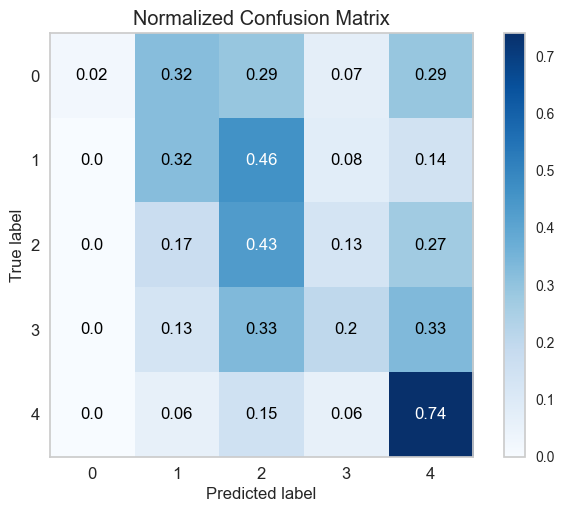

In [97]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred_gs, normalize=True)

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, cohen_kappa_score

def plot_roc_multi(y_test, y_pred):
    n_classes = len(np.unique(y_test))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'pink']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

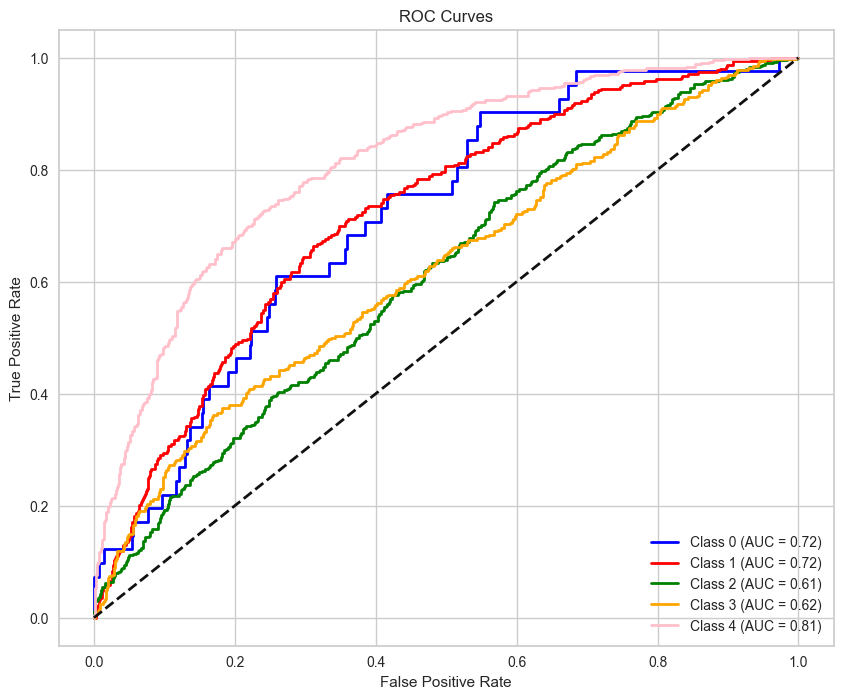

In [103]:
plot_roc_multi(y_test, y_pred_proba_gs)

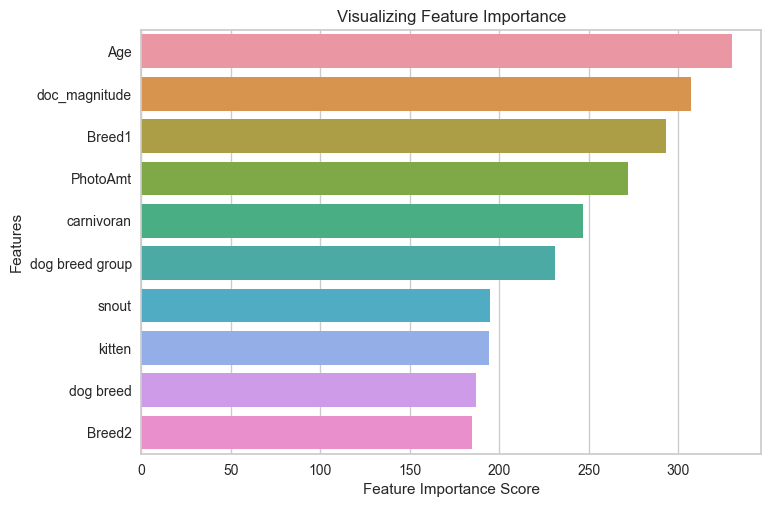

In [104]:
gs_feature_imp = pd.Series(modelo_gs.feature_importances_,index=x_train.columns).sort_values(ascending=False)

sns.barplot(x=gs_feature_imp[0:10,], y=gs_feature_imp[0:10,].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
plt.show()

# Anexos

# Pycaret

In [80]:
exp = setup(data, target="AdoptionSpeed")

,Description,Value
0,Session id,7400
1,Target,AdoptionSpeed
2,Target type,Multiclass
3,Original data shape,"(14993, 1312)"
4,Transformed data shape,"(14993, 1213)"
5,Transformed train set shape,"(10495, 1213)"
6,Transformed test set shape,"(4498, 1213)"
7,Numeric features,1311
8,Rows with missing values,100.0%
9,Preprocess,True


In [81]:
best_models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.4007,0.6734,0.4007,0.3785,0.3811,0.1953,0.1982,75.8480
rf,Random Forest Classifier,0.3955,0.6578,0.3955,0.3896,0.3703,0.1852,0.1901,2.0540
et,Extra Trees Classifier,0.3942,0.6580,0.3942,0.3957,0.3714,0.1840,0.1886,3.4810
xgboost,Extreme Gradient Boosting,0.3925,0.6595,0.3925,0.3802,0.3776,0.1860,0.1880,3.8560
lightgbm,Light Gradient Boosting Machine,0.3912,0.6608,0.3912,0.3788,0.3769,0.1851,0.1868,2.8280
gbc,Gradient Boosting Classifier,0.3901,0.6618,0.3901,0.3731,0.3659,0.1799,0.1846,12.2820
ada,Ada Boost Classifier,0.3795,0.6274,0.3795,0.3627,0.3576,0.1659,0.1696,2.3220
ridge,Ridge Classifier,0.3612,0.0000,0.3612,0.3444,0.3354,0.1386,0.1433,0.8510
knn,K Neighbors Classifier,0.3436,0.6047,0.3436,0.3522,0.3432,0.1351,0.1363,1.5850
lda,Linear Discriminant Analysis,0.3363,0.5963,0.3363,0.3268,0.3255,0.1161,0.1174,3.0440


In [82]:
selected_model = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4076,0.6759,0.4076,0.4122,0.3815,0.2016,0.2069
1,0.4029,0.6628,0.4029,0.4099,0.3785,0.1955,0.2005
2,0.4086,0.6772,0.4086,0.4271,0.3829,0.2018,0.2082
3,0.3781,0.6383,0.3781,0.3474,0.3491,0.1617,0.1660
4,0.3686,0.6405,0.3686,0.3512,0.3461,0.1487,0.1526
5,0.3966,0.6369,0.3966,0.3716,0.3675,0.1861,0.1915
6,0.3823,0.6543,0.3823,0.3824,0.3554,0.1669,0.1717
7,0.3994,0.6673,0.3994,0.4073,0.3764,0.1912,0.1958
8,0.4090,0.6675,0.4090,0.4074,0.3895,0.2049,0.2093


In [83]:
# Evaluar el modelo en el conjunto de prueba
evaluate_model(selected_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…